In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import matplotlib.pyplot as plt
#import seaborn as sns 
#%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
#from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under 
# the input directory. Any results you write to the current directory are saved as output.
import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/kaggle_task.csv
data/.DS_Store
data/submission.csv
data/main_task.csv


In [2]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## ЗАГРУЗКА БИБЛИОТЕК

In [3]:
import pandas as pd

# ТЕПЛОВАЯ КАРТА КОРРЕЛЯЦИОННОГО АНАЛИЗА МЕЖДУ ВЕЛИЧИНАМИ - степень связи (коэффициент корреляции) может 
# меняться от -1 до +1: чем ближе абсолютное значение коэффициента к 1, тем сильнее связь между признаками.
import seaborn as sns
#import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

# СПЕЦИАЛЬНЫЙ ИНСТРУМЕНТ ДЛЯ РАЗБИВКИ ДАТАФРЕЙМА НА ЧАСТИ, необходимые для обучения и тестирования модели
from sklearn.model_selection import train_test_split

# БИБЛИОТЕКИ, НЕОБХОДИМЫЕ ДЛЯ СОЗДАНИЯ, ОБУЧЕНИЯ И ТЕСТИРОВАНИЯ МОДЕЛИ
from sklearn.ensemble import RandomForestRegressor # Инструмент для создания и обучения модели
from sklearn import metrics # Инструменты для оценки точности модели

import numpy as np

import math as math

from collections import Counter

from datetime import datetime, date

import json
from pprint import pprint

## ФУНКЦИЯ train_model()
Создаем датафрейм df и убираем лишние столбцы; разбиваем датафрейм на части X (X_train, X_test) и y (y_train, y_test), необходимые для работы с моделью; создаем, обучаем и тестируем модель; определяем показатель эффективности и значимость переменных.

In [4]:
# В Питоне используется т.н. генератор псевдо случайных чисел - random выдает не случайное число, 
# а число которое вычисляется алгоритмом на осное другого числа, по умолчанию это текущее время. 
# random.seed позволяет изменить число, которое передается в random для генерации случайного числа, 
# а т.к. "случайные" числа выдаются одним и тем же алгоритмом, то при одинаковом параметре в random.seed 
# будут и одинаковые "случайные" числа.
random_seed = 42

In [5]:
def train_model(display_df=1, display_importance=1, display_barh=0, barh_size=4, delete=[], unite=[[]]):
    global df_all
    
# УБИРАЕМ ВСЕ ЛИШНИЕ СТОЛБЦЫ (нечисловые данные) ИЗ ДАТАФРЕЙМА
    # Создаем список столбцов для удаления из датафрейма
    drop_columns = [column for column in df_all.columns if df_all[column].dtypes=='object']
    # Если при вызове функции заданы еще какие-то столбцы для удаления, добаляем и их к списку
    drop_columns += delete    
    # Удаляем из df_all все столбцы из списка drop_columns и сохраняем результат в новый датафрейм df
    df = df_all.drop(drop_columns, axis=1) # df - столбцы с числовыми данными
    df = df.fillna(0) # Заполняем пропуски в df 0 (нулями)
    # Если при вызове функции не задано иначе, отображаем одну строку датафрейма df на экран
    if display_df==1: display(df.drop(['sample'], axis=1).sample(1))
    
# РАЗБИВАЕМ ДАТАФРЕЙМ НА ЧАСТИ, НЕОБХОДИМЫЕ ДЛЯ ОБУЧЕНИЯ И ТЕСТИРОВАНИЯ МОДЕЛИ:
    #test_data = df.query('sample == 0').drop(['sample'], axis=1)
    # Выделяем из датафрейма только записи с заданной информацией о рейтинге ресторанов
    train_data = df.query('sample == 1').drop(['sample'], axis=1)
    # Разбиваем выделенные записи на 2 части:
    X = train_data.drop(['Rating'], axis=1) # Х - данные с информацией о ресторанах
    y = train_data['Rating'] # у - целевая переменная (рейтинги ресторанов)
    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
    # Для тестирования мы будем использовать 25% от исходного датасета.
    # Нужный инструмент для разбивки уже загружен:
    #from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_seed)
    # проверяем
    #print(test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape)
    
    
# СОЗДАЁМ, ОБУЧАЕМ И ТЕСТИРУЕМ МОДЕЛЬ:
    # Необходимые библиотеки уже импортированы:
    #from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
    #from sklearn import metrics # инструменты для оценки точности модели    
    # Создаём модель
    regr = RandomForestRegressor(n_estimators=100, random_state=random_seed) # , verbose=1, n_jobs=-1
    # Обучаем модель на тестовом наборе данных
    regr.fit(X_train, y_train)
    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
    # Предсказанные значения записываем в переменную y_pred
    y_pred = np.round(regr.predict(X_test), 1)

# MAE - СРАВНИВАЕМ ПРЕДСКАЗАННЫЕ ЗНАЧЕНИЯ (y_pred) С РЕАЛЬНЫМИ (y_test):
    # Насколько в среднем отличаются предсказанные значения (y_pred) и реальные (y_test)
    # Метрика - Mean Absolute Error (MAE) - показывает среднее отклонение предсказанных значений от фактических
    MAE = metrics.mean_absolute_error(y_test, y_pred) # = abs(y_pred - y_test)
    print('\nMAE:', round(MAE, 2), end='\t')

# ТОЧНОСТЬ - ОПРЕДЕЛЯЕМ ПОКАЗАТЕЛИ ЭФФЕКТИВНОСТИ:
    errors = abs(y_pred-y_test) # Считаем абсолютые ошибки
    mape = 100*(errors/y_test) # Считаем средний абсолютный процент ошибки (MAPE)
    accuracy = 100-np.mean(mape) # Считаем и выводим точность
    print('Точность:', round(accuracy, 2), '%')
    
# ОКРУГЛЯЕМ ПРЕДСКАЗАННЫЕ ЗНАЧЕНИЯ В СООТВЕТСТВИИ С ШАГОМ ЗНАЧЕНИЙ РЕЙТИНГА И СНОВА СЧИТАЕМ MAE И ТОЧНОСТЬ
    # (1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0)
    for i in range(0,len(y_pred)): y_pred[i] = (round(y_pred[i]*2,0)/2)
    # Вычисляем МAE, используя округленные предсказанные значения
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    print('    ', round(MAE, 2), end='\t')
    # Вычисляем Точность модели
    errors = abs(y_pred-y_test) # Считаем абсолютые ошибки
    mape = 100*(errors/y_test) # Считаем средний абсолютный процент ошибки (MAPE)
    accuracy = 100-np.mean(mape) # Считаем и выводим точность
    print('         ', round(accuracy, 2), '%\t(после округления предсказанных значений)')    

# ЗНАЧИМОСТЬ ПЕРЕМЕННЫХ:
    # Относительные значения переменных показывают, насколько включение определенной переменной 
    # может улучшить прогноз - в RandomForestRegressor есть возможность вывести самые важные 
    # признаки для модели
    importances = list(regr.feature_importances_)
    # Список кортежей из переменной и ее относительного значения
    X_importances = [(feature, importance) for feature, importance in zip(list(X.columns), importances)]
    
    if display_importance==1:
        
        # Проверка, задан ли необязательный аргумент unite - список списков названий переменных, относительное 
        # значение которых нужно воспринимать суммарно (например, при прямом кодировании городов получим N 
        # столбцов в датафрейме и, следовательно, столько же переменных в X_importances каждая со своим 
        # относительным значением)
        if len(unite[0])>0:
            for unite_list in unite: # Проход по элементам списка unite (элементы - тоже списки)
                united_importance = 0 # Суммарная значимость
                for X_variable, X_value in X_importances: # Перебор переменных и их относительных значений
                    if unite_list.count(X_variable)>0: # Нужная переменная (заданная в unite)
                        united_importance += X_value # считаем суммарную значимость
                X_importances.append((unite_list[0]+' SUM', united_importance)) # добавить к X_importances
        
        # Сортировка переменных по убыванию относительной значимости
        # Возьмем за пороговую значимость 0.1 (остальные переменные "слабые") - тогда минимальное значение, 
        # округляемое до 0.1, равно 0.05 вывод на экран переменных с относительной значимостью больше 0.05
        low_importance_variables=0
        print('-------------------------------------------------')
        
        for X_variable, X_value in X_importances:
            if X_value>=0.05: # Значения, большие или равные минимальной пороговой значимости
                # Переменная не задана в unite
                if len(unite[0])==0 or (len(unite[0])>0 and str(unite).find(X_variable)==-1):
                    print('Переменная: {:20} Значимость: {}'.format(X_variable, round(X_value, 2)))
                # Переменная указана в unite, и она - не объединяющее серию переменных название
                elif (str(unite).find(X_variable) and str(X_variable).find('ALL')==-1):
                    low_importance_variables += 1
            else: # Значения, меньше минимальной пороговой значимости
                # Переменная не название в unite (потому что такого столбца в датафрейме нет)
                if str(X_variable).find('ALL')==-1:
                    low_importance_variables += 1
        
        if low_importance_variables>0:
            print()
            temp=[]
            for X_variable, X_value in X_importances:
                if X_value<0.05:
                    if len(unite[0])>0: # Если задан аргумент unite
                        if str(unite).find(X_variable)==-1: # Если X_variable не из unite
                            print('Переменная: {:20} Значимость: {}'.format(X_variable, round(X_value, 2)))
                        else: # если X_variable из unite
                            for unite_list in unite:
                                # Если это объединяющее серию переменных название из unite
                                if X_variable==unite_list[0]+' SUM':
                                    print('Переменная: {:20} Значимость: {}'.format(X_variable, 
                                                                                    round(X_value, 2)))
                                # Если это переменная из unite, но не объединяющее серию переменных название
                                elif unite_list.count(X_variable)>0:
                                    if unite_list.count(unite_list[0]+' SUM')==0: 
                                        unite_list.append(unite_list[0]+' SUM')
                    else: # unite не задан
                        print('Переменная: {:20} Значимость: {}'.format(X_variable, round(X_value, 2)))
            if len(temp)>0:
                print('Остальные переменные - часть {}'.format(temp))
                print('Их индивидуальная значимость не учитывается')
        print('-------------------------------------------------')
    
    if display_barh==1:
        plt.rcParams['figure.figsize'] = (barh_size, barh_size)
        if len(unite[0])>0:
            for unite_list in unite:
                for X_variable, X_value in X_importances:
                    if X_variable==(unite_list[0]+' SUM'): X_importances.remove((X_variable, X_value))
        pd.Series([x[1] for x in X_importances], [x[0] for x in X_importances]).nlargest(15).plot(kind='barh')

## ФУНКЦИЯ my_heatmap()
Функция отображения тепловой карты коэффициентов корреляции между количественными признаками.

In [6]:
def my_heatmap(heatmap_size=5, delete=[], draw_heatmap=1, threshold=0.5, display_correlation=1):
    global df_all
    
    # Создаем список столбцов для удаления из датафрейма
    drop_columns = [column for column in df_all.columns if df_all[column].dtypes=='object']
    # Если при вызове функции заданы еще какие-то столбцы для удаления, добаляем и их к списку
    drop_columns += delete
    # Вспомогательный столбец 'sample' нужно тоже удалить
    drop_columns += ['sample']
    # Коэффициенты корреляции между количественными признаками, содержащимися в датафрейме - метод corr().
    correlation = df_all.query('sample == 1').drop(drop_columns, axis=1).corr()
    
    if draw_heatmap==1:
        # Тепловая карта значений коэффициентов корреляции
        plt.rcParams['figure.figsize'] = (heatmap_size, heatmap_size) # размер области отображения
        sns.heatmap(correlation, cmap='Accent', center=.2, 
                    robust=False, fmt='.1g', linewidths=0.01, linecolor='white', square=True)
    
    # Наибольшие коэффициенты корреляции
    # Матрица симметрична, поэтому нужен верхний треугольник матрицы без диагонали
    corrpairs = (correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(np.bool))
                 .stack().sort_values(ascending=False))
    
    if display_correlation==1:
        for corrpairs_variable, corrpairs_value in corrpairs.items():
            if abs(round(corrpairs_value, 1))>=threshold and corrpairs_variable.count('Rating')==0:
                if corrpairs_value<0: space=''
                else: space=' '
                print('[{}{} ] {}'.format(space, round(corrpairs_value, 1), 
                                          str(corrpairs_variable).replace("('", "")
                                          .replace("')", "").replace("', '", " - ")))

## ФУНКЦИЯ my_pairplot()
Гистограммы распределения количественных признаков и особенности связей между ними.

In [7]:
def my_pairplot(delete=[]):
    global df_all
        
    # Создаем список столбцов для удаления из датафрейма
    drop_columns = [column for column in df_all.columns if df_all[column].dtypes=='object']
    # Если при вызове функции заданы еще какие-то столбцы для удаления, добаляем и их к списку
    drop_columns += delete
    # Вспомогательный столбец 'sample' нужно тоже удалить
    drop_columns += ['sample']
    
    sns.pairplot(df_all.query('sample == 1').drop(drop_columns, axis=1))

___

## ЗАГРУЗКА ДАННЫХ

In [8]:
directory = 'data/' #'/kaggle/input/sf-dst-restaurant-rating/'
filename_train = 'main_task.csv'
filename_test = 'kaggle_task.csv'
filename_submission = 'submission.csv'

### ДАТАФРЕЙМ sample_submission

In [9]:
sample_submission = pd.read_csv(directory+filename_submission)

### ДАТАФРЕЙМ df_train

In [10]:
df_train = pd.read_csv(directory+filename_train)

In [11]:
df_train.sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
32603,id_5729,Milan,['Healthy'],5732.0,3.5,NaN,23.0,"[['Tourist food as usual', 'GREAT VIEW FOOD SO...",/Restaurant_Review-g187849-d2509872-Reviews-So...,d2509872
39809,id_416,Stockholm,"['Middle Eastern', 'Persian', 'Vegetarian Frie...",417.0,4.0,$$ - $$$,134.0,[['Fancy Persian restaurant with great servic....,/Restaurant_Review-g189852-d4858640-Reviews-Sh...,d4858640


### ДАТАФРЕЙМ df_test

In [12]:
df_test = pd.read_csv(directory+filename_test)

In [13]:
df_test.sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
2059,id_2059,London,"['Italian', 'French', 'Cafe', 'European', 'Veg...",3611.0,$,154.0,"[['Nice place near British Museum', 'Great for...",/Restaurant_Review-g186338-d7702912-Reviews-Po...,d7702912
2971,id_2971,London,NaN,12539.0,NaN,2.0,"[['Quiet and space - in Central Brixton!', 'Co...",/Restaurant_Review-g186338-d11992738-Reviews-K...,d11992738


### df_all = ОБЪЕДИНЯЕМ df_test с df_train - важно для корректной обработки признаков

In [14]:
# Помечаем датафреймы в едином датафрейме с помощью столбца 'sample'
df_train['sample'] = 1 # тренировочный датафрейм
df_test['sample'] = 0 # тестовый датафрейм

In [15]:
# создаем недостающий столбец 'Rating' (должны будем его предсказать) в тестовом датафрейме df_test 
# и заполняем его нулями
df_test['Rating'] = 0

In [16]:
print(sorted(list(df_test.columns))==sorted(list(df_train.columns)))

True


In [17]:
# объединяем оба датафрейма в один для обучения модели
df_all = df_test.append(df_train, sort=False).reset_index(drop=True)

In [18]:
train_model()

,Ranking,Number of Reviews,Rating
39158,4248.0,10.0,4.0



MAE: 0.42	Точность: 87.74 %
     0.41	          88.21 %	(после округления предсказанных значений)
-------------------------------------------------
Переменная: Ranking              Значимость: 0.75
Переменная: Number of Reviews    Значимость: 0.25
-------------------------------------------------


___

# ОЧИСТКА ДАННЫХ И ГЕНЕРАЦИЯ НОВЫХ ПРИЗНАКОВ

___

## [ Простейший первичный анализ датафрейма ]

### 'Restaurant_id'
Посмотрим, что означает 'Restaurant ID' в датафрейме. Это один и тот же ресторан? Ресторанная сеть? В таком случае 'Cuisine Style' должен, по идее, совпадать. А что с 'Ranking'? Проверим:

In [19]:
display(df_all[df_all['Restaurant_id']=='id_1717'][['Ranking', 'Cuisine Style']].nunique())

Ranking          3
Cuisine Style    5
dtype: int64

Похоже, один и тот же 'Restaurant_id' вовсе не значит один и тот же ресторан - у 'Restaurant_id' выше 3 разных значения 'Ranking' и 5 разных значений 'Cuisine Style'. 'Rating' тоже не совпадает. Аналогично, у одного и того же 'Ranking' может быть разный 'Restaurant_id':

In [20]:
display(df_all[df_all['Ranking']==1719][['Restaurant_id', 'Cuisine Style']].nunique())

Restaurant_id    7
Cuisine Style    8
dtype: int64

In [21]:
# Значения нового столбца 'Restaurant ID' - это инфо из столбца 'Restaurant_id' без 'id_'
df_all['Restaurant ID'] = df_all['Restaurant_id'].apply(lambda x: int(x[3::]))

### 'ID_TA'

In [22]:
print(df_all['ID_TA'].count(), ' | ', df_all['ID_TA'].nunique())

50000  |  49963


Уникальных 'ID_TA' почти столько же, сколько записей в датафрейме. Вытаскивать этот параметр нет смысла.

### 'URL_TA'

In [23]:
# 'URL_TA' > 'URL_TA gID'
df_all[['URL_TA', 'ID_TA']].head(1)

,URL_TA,ID_TA
0,/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918


In [24]:
# Есть 2 цифровых значения: g1068497 и d12160475;
# значения типа d12160475 полностью совпадают со значением в столбце 'ID_TA'
# Извлечем цифровые данные из значений типа g1068497
df_all['URL_TA gID'] = df_all['URL_TA'].apply(lambda x: int((str(x).split('-'))[1][1::]))

Если взять пример выше: '/Restaurant_Review-g1068497-d12160475-Reviews-Ispahan-Auderghem_Brussels.html' и посмотреть, что выдает сайт tripadvisor.com, станет ясно, что это ссылка на конкретный ресторан в Брюсселе, Бельгия. Если же посмотреть, что выдает тот же сайт на 'g1068497' - попадаем на список разных мест в Брюсселе, Бельгия. Следовательно, значения типа 'g1068497' - географический показатель.

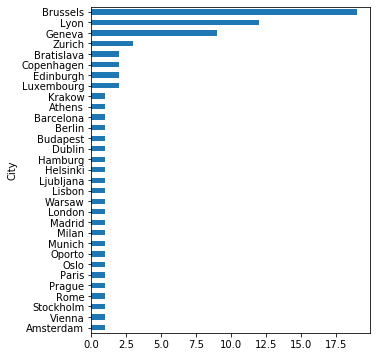

In [25]:
df_all.groupby('City')['URL_TA gID'].nunique().sort_values().plot(kind='barh', figsize=(5, 6))

Видно, что некоторые города представлены несколькими значениями в столбце 'URL_TA gID', в то время как остальные - всего одним. 'URL_TA gID' - СПОРНЫЙ ПРИЗНАК.

### 'Price Range'
Закодируем строковые значения столбца 'Price Range' числами.

In [26]:
# Цены даны в 3 категориях от самых дешевых ($) до самых дорогих ($$$$) - кодировка цен числами 
# 0 (NaN), 1 ($), 2 ($$ - $$$) и 3 ($$$$) логически сохраняет эту иерархию
PriceCategories = { '$': { 'code': 1 }, '$$ - $$$': { 'code': 2 }, '$$$$': { 'code': 3 } }

In [27]:
# Столбцу 'Price Category' присваивается значение ключа из словаря PriceCategories если ключ совпадает со
# значением в столбце 'Price Range', или 0 - если 'Price Range' NaN
df_all['Price category'] = df_all['Price Range'].apply(lambda x: PriceCategories[x]['code'] 
                                                       if PriceCategories.get(x) else x)

### NaN

In [28]:
df_all.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
Restaurant ID            0
URL_TA gID               0
Price category       17361
dtype: int64

Прежде, чем заполнять пропуски в столбцах какими-то значениями, посмотрим на модель, если эти пропуски
просто заполнить нулями.

In [29]:
train_model()

,Ranking,Number of Reviews,Rating,Restaurant ID,URL_TA gID,Price category
37277,941.0,63.0,3.5,940,1136495,2.0



MAE: 0.21	Точность: 94.09 %
     0.19	          94.68 %	(после округления предсказанных значений)
-------------------------------------------------
Переменная: Ranking              Значимость: 0.24
Переменная: Number of Reviews    Значимость: 0.17
Переменная: Restaurant ID        Значимость: 0.33
Переменная: URL_TA gID           Значимость: 0.24

Переменная: Price category       Значимость: 0.02
-------------------------------------------------


[ 1.0 ] Ranking - Restaurant ID


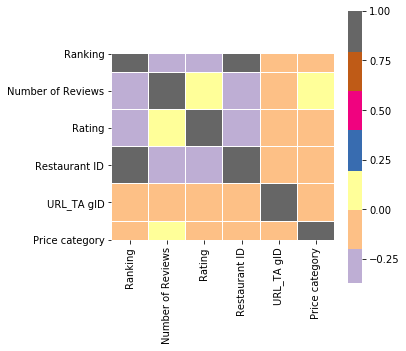

In [30]:
my_heatmap()

Высокий коэффициент корреляции между 'Ranking' и 'Restaurant ID' позволяет предположить целесообразность использования только один из показателей. Высокий коэффициент корреляции между ними показывает, что их значимость (Importance) взаимозависима и при удалении одного из показателей пропорционально вырастет значимость другого. При этом значение MAE и Точность измениться не должны.

In [31]:
train_model(display_df=0, delete=['Restaurant ID'])


MAE: 0.22	Точность: 94.08 %
     0.19	          94.68 %	(после округления предсказанных значений)
-------------------------------------------------
Переменная: Ranking              Значимость: 0.57
Переменная: Number of Reviews    Значимость: 0.17
Переменная: URL_TA gID           Значимость: 0.24

Переменная: Price category       Значимость: 0.02
-------------------------------------------------


Предположения подтвердились.

In [32]:
df_all.drop('Restaurant ID', axis=1, inplace=True)

### NaN 'Number of Reviews'

In [33]:
# 'Number of Reviews'
df_all['Number of Reviews'].isna().sum()

3200

Часть данных 'Number of Reviews' - это NaN. Посмотрим на другие столбцы при 'Number of Reviews', равных NaN:

In [34]:
display(round(df_all[df_all['Number of Reviews'].isna()]['Cuisine Style']
              .value_counts(dropna=False, normalize=True).head(1)*100,0))

display(round(df_all[df_all['Number of Reviews'].isna()]['Price Range']
              .value_counts(dropna=False, normalize=True).head(1)*100,0))

# Заменим сначала все NaN значения 'Reviews' на '[[], []]'
df_all.Reviews = df_all.Reviews.apply(lambda x: '[[], []]' if x!=x else x)

display(round(df_all[df_all['Number of Reviews'].isna()]['Reviews']
              .value_counts(dropna=False, normalize=True).head(1)*100,0))

NaN    53.0
Name: Cuisine Style, dtype: float64

NaN    83.0
Name: Price Range, dtype: float64

[[], []]    63.0
Name: Reviews, dtype: float64

In [35]:
df_all.loc[(df_all['Cuisine Style'].isna()) & (df_all['Price Range'].isna()) 
           & (df_all['Reviews']=='[[], []]')]['Number of Reviews'].value_counts(dropna=False).head(1)

NaN    1099
Name: Number of Reviews, dtype: int64

Интересно - для NaN значений 'Number of Reviews' - 53% 'Cuisine Style', 83% 'Price Range' и 63% 'Reviews' - тоже имеют значения NaN. Это означает, что в больше, чем половине случаев все эти столбцы остаются незаполненными одновременно или в разных сочетаниях с 'Number of Reviews' (как уже известно - треть NaN 'Number of Reviews' встречается при NaN всех трех вместе).

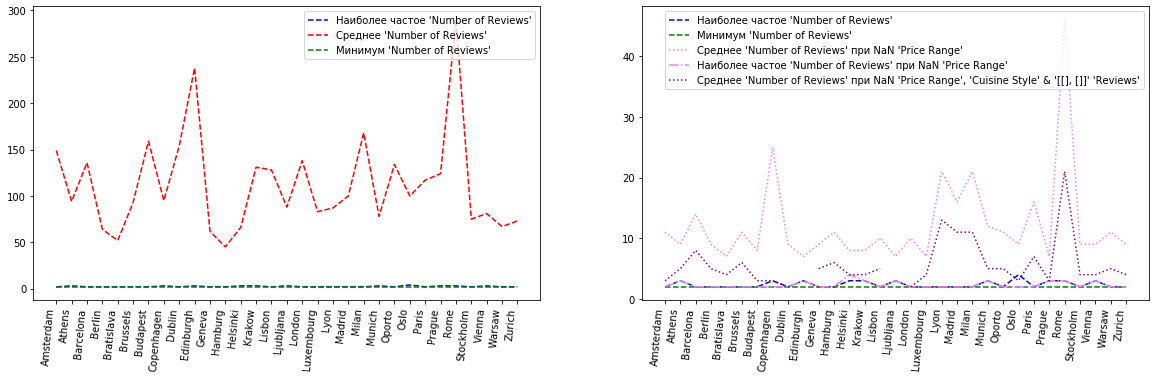

In [36]:
fig, axes = plt.subplots(1, 2, figsize=[20,6])
fig.autofmt_xdate(rotation=85)

axes[0].plot(df_all.groupby('City')['Number of Reviews'].agg(lambda x: pd.Series.value_counts(x).idxmax()), 
             color='blue', linestyle='--', label="Наиболее частое 'Number of Reviews'")
axes[0].plot(round(df_all.groupby('City')['Number of Reviews'].mean(), 0), color='red', linestyle='--', 
             label="Среднее 'Number of Reviews'")
axes[0].plot(df_all.groupby('City')['Number of Reviews'].min(), color='green', linestyle='--', 
             label="Минимум 'Number of Reviews'")
axes[0].legend(loc=1)

axes[1].plot(df_all.groupby('City')['Number of Reviews'].agg(lambda x: pd.Series.value_counts(x).idxmax()), 
             color='blue', linestyle='--', label="Наиболее частое 'Number of Reviews'")
axes[1].plot(df_all.groupby('City')['Number of Reviews'].min(), color='green', linestyle='--', 
             label="Минимум 'Number of Reviews'")
axes[1].plot(round(df_all[df_all['Price Range'].isna()].groupby('City')['Number of Reviews'].mean(),0), 
             color='violet', linestyle=':', label="Среднее 'Number of Reviews' при NaN 'Price Range'")
axes[1].plot(df_all[df_all['Price Range'].isna()].groupby('City')
             ['Number of Reviews'].agg(lambda x: pd.Series.value_counts(x).idxmax()), 
             color='violet', linestyle='-.', label="Наиболее частое 'Number of Reviews' при NaN 'Price Range'")
axes[1].plot(round(df_all.loc[(df_all['Cuisine Style'].isna()) & (df_all['Price Range'].isna()) & 
                              (df_all['Reviews']=='[[], []]')].groupby('City')['Number of Reviews'].mean(),0), 
             color='purple', linestyle=':', 
             label="Среднее 'Number of Reviews' при NaN 'Price Range', 'Cuisine Style' & '[[], []]' 'Reviews'")
axes[1].legend(loc=1)

Соотнесение NaN 'Number of Reviews' c NaN 'Cuisine Style', 'Price Range' & 'Reviews' - весьма сомнительно и не стоит свеч. Гораздо надежнее работать просто с 'Number of Reviews'. Можно заполнить NaN 'Number of Reviews' средними значениями 'Number of Reviews' по городу.

In [37]:
# Среднее значение 'Number of Reviews' по городу
display(round(df_all.groupby('City')['Number of Reviews'].mean().sort_values(ascending=False).head(5),0))

# Минимальное значение 'Number of Reviews' по городу
display(round(df_all.groupby('City')['Number of Reviews'].min().sort_values(ascending=False).head(5),0))

City
Rome         290.0
Edinburgh    238.0
Milan        168.0
Budapest     159.0
Dublin       154.0
Name: Number of Reviews, dtype: float64

City
Zurich       2.0
Lisbon       2.0
Athens       2.0
Barcelona    2.0
Berlin       2.0
Name: Number of Reviews, dtype: float64

Средние значения выглядят как довольно большой скачок от нуля и от минимального значения.

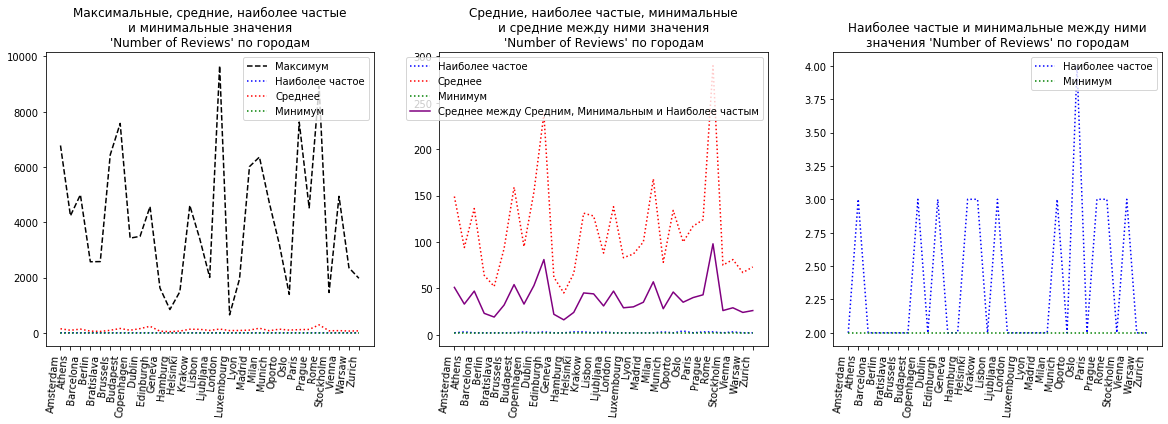

In [38]:
fig, axes = plt.subplots(1, 3, figsize=[20,6])
fig.autofmt_xdate(rotation=85)

axes[0].plot(df_all.groupby('City')['Number of Reviews'].max(), color='black', linestyle='--',label="Максимум")
axes[0].plot(df_all.groupby('City')['Number of Reviews'].agg(lambda x: pd.Series.value_counts(x).idxmax()), 
             color='blue', linestyle=':', label="Наиболее частое")
axes[0].plot(round(df_all.groupby('City')['Number of Reviews'].mean(), 0), color='red', linestyle=':', 
             label="Среднее")
axes[0].plot(df_all.groupby('City')['Number of Reviews'].min(), color='green', linestyle=':', label="Минимум")
axes[0].legend(loc=1)
axes[0].set_title(
    "Максимальные, средние, наиболее частые\nи минимальные значения\n'Number of Reviews' по городам")

axes[1].plot(df_all.groupby('City')['Number of Reviews'].agg(lambda x: pd.Series.value_counts(x).idxmax()), 
             color='blue', linestyle=':', label="Наиболее частое")
axes[1].plot(round(df_all.groupby('City')['Number of Reviews'].mean(), 0), color='red', linestyle=':', 
             label="Среднее")
axes[1].plot(df_all.groupby('City')['Number of Reviews'].min(), color='green', linestyle=':', label="Минимум")
axes[1].plot([round(np.mean(y), 0) for y in 
              zip(df_all.groupby('City')['Number of Reviews'].agg(
                  lambda x: pd.Series.value_counts(x).idxmax()),
                  df_all.groupby('City')['Number of Reviews'].min(), 
                  round(df_all.groupby('City')['Number of Reviews'].mean(), 0))], color='purple', 
             linestyle='-', label="Среднее между Средним, Минимальным и Наиболее частым")
axes[1].legend(loc=1)
axes[1].set_title(
    "Cредние, наиболее частые, минимальные\nи средние между ними значения\n'Number of Reviews' по городам")

axes[2].plot(df_all.groupby('City')['Number of Reviews'].agg(lambda x: pd.Series.value_counts(x).idxmax()), 
             color='blue', linestyle=':', label="Наиболее частое")
axes[2].plot(df_all.groupby('City')['Number of Reviews'].min(), color='green', linestyle=':', label="Минимум")
axes[2].legend(loc=1)
axes[2].set_title(
    "Наиболее частые и минимальные между ними\nзначения 'Number of Reviews' по городам")
print()

Столь заметный скачок среднего относительно минимального и наиболее частого обусловлен высокими значениями максимума. Данную выборку лучше характеризует наиболее частое - этим значением и заполним пропуски в 'Number of Reviews'.

In [39]:
NaN = df_all.groupby('City')['Number of Reviews'].agg(lambda x: pd.Series.value_counts(x).idxmax())

In [40]:
for city in df_all.City.unique():
    df_all['Number of Reviews']=df_all.apply(lambda x: NaN[city] if x['City']==city 
                                             and x['Number of Reviews']!=x['Number of Reviews'] 
                                             else x['Number of Reviews'], axis=1)

### NaN 'Price Range'
Посмотрим теперь по тому же принципу на 'Price Range'. Cначала закодируем строковые значения столбца 'Price Range' числами.

In [41]:
df_all['Price category'].isna().sum()

17361

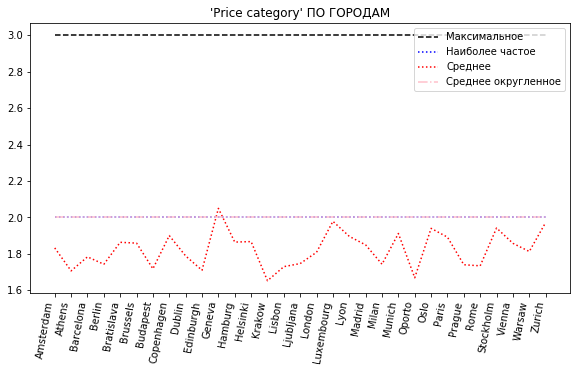

In [42]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1.5, 0.75])
fig.autofmt_xdate(rotation=80)

axes.plot(df_all.groupby('City')['Price category'].max(), color='black', linestyle='--', 
          label="Максимальное")
axes.plot(df_all.groupby('City')['Price category'].agg(lambda x: pd.Series.value_counts(x).idxmax()), 
          color='blue', linestyle=':', label="Наиболее частое")
axes.plot(df_all.groupby('City')['Price category'].mean(), color='red', linestyle=':', 
          label="Среднее")
axes.plot(round(df_all.groupby('City')['Price category'].mean(),0), color='pink', linestyle='-.', 
          label="Среднее округленное")
axes.set_title("'Price category' ПО ГОРОДАМ")
axes.legend(loc=1)

Наиболее частое полностью совпадает со средним округленным - заполним этими значениями NaN в 'Price category'.

In [43]:
NaN = df_all.groupby('City')['Price category'].agg(lambda x: pd.Series.value_counts(x).idxmax())

In [44]:
for city in df_all.City.unique():
    df_all['Price category']=df_all.apply(lambda x: NaN[city] if x['City']==city 
                                          and x['Price category']!=x['Price category'] 
                                          else x['Price category'], axis=1)

In [45]:
train_model()

,Ranking,Number of Reviews,Rating,URL_TA gID,Price category
48676,1347.0,52.0,4.0,188590,1.0



MAE: 0.22	Точность: 94.07 %
     0.19	          94.64 %	(после округления предсказанных значений)
-------------------------------------------------
Переменная: Ranking              Значимость: 0.58
Переменная: Number of Reviews    Значимость: 0.17
Переменная: URL_TA gID           Значимость: 0.25

Переменная: Price category       Значимость: 0.01
-------------------------------------------------


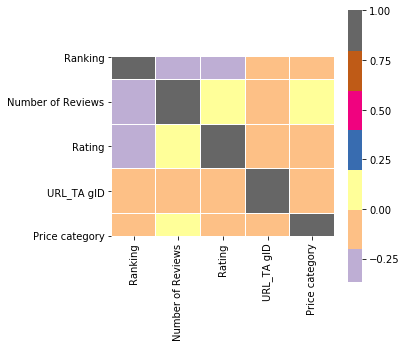

In [46]:
my_heatmap()

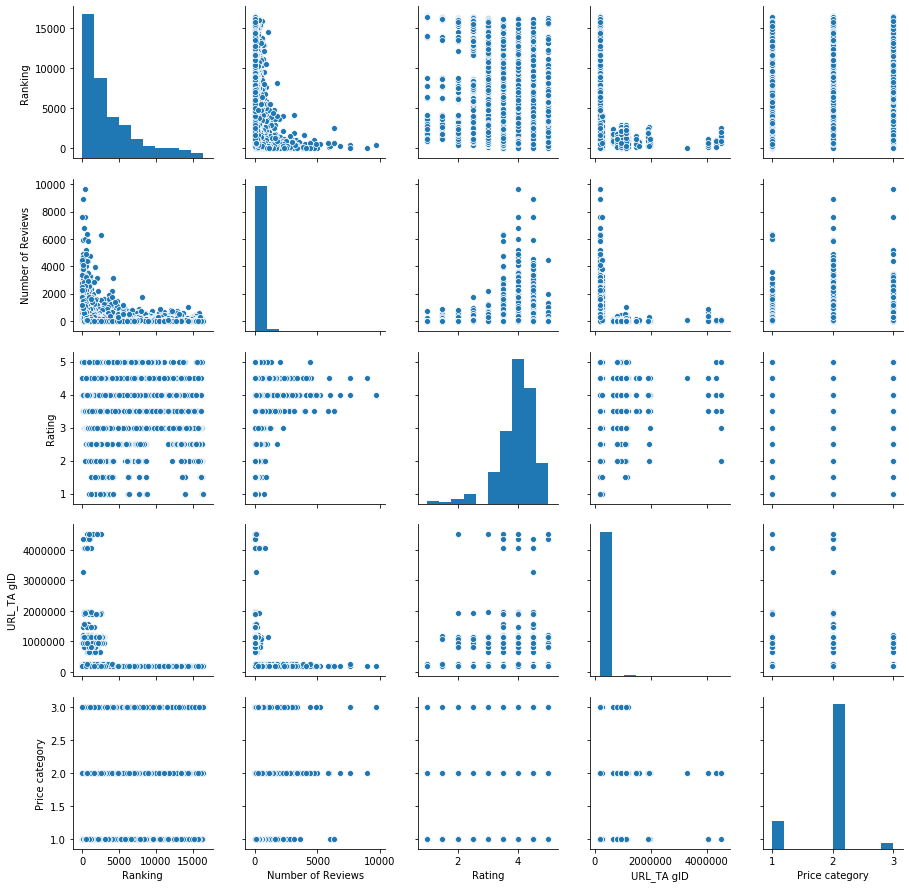

In [47]:
my_pairplot()

___

### [ информация о странах > в словарь 'сountries_info' ]

In [48]:
# СЛОВАРЬ СТРАН (https://www.worldometers.info/world-population/portugal-population/)
сountries_info = {
    'Austria': {'cap': 'Vienna', 'pop': 8984912, 'cuis': 'Austrian', 'reg': ['European', 'Central European']},
    'Belgium': {'cap': 'Brussels', 'pop': 11568565, 'cuis': 'Belgian', 'reg': ['European']},
    'Czech Republic': {'cap': 'Prague', 'pop': 10700709, 'cuis': 'Czech', 
                       'reg': ['European', 'Central European']},
    'Denmark': {'cap': 'Copenhagen', 'pop': 5783694, 'cuis': 'Danish', 'reg': ['European', 'Scandinavian']},
    'England': {'cap': 'London', 'pop': 56000000, 'cuis': 'British', 'reg': ['European']},
    'Finland': { 'cap': 'Helsinki', 'pop': 5537137, 'cuis': 'Finnish', 'reg': ['European']},
    'France': {'cap': 'Paris', 'pop': 65213347, 'cuis': 'French', 'reg': ['European', 'Mediterranean']},
    'Germany': {'cap': 'Berlin', 'pop': 83672230, 'cuis': 'German', 'reg': ['European', 'Central European']},
    'Greece': { 'cap': 'Athens', 'pop': 10444100, 'cuis': 'Greek', 'reg': ['European', 'Mediterranean']},
    'Hungary': {'cap': 'Budapest', 'pop': 9670516, 'cuis': 'Hungarian', 
                'reg': ['European', 'Central European']},
    'Ireland': {'cap': 'Dublin', 'pop': 4914590, 'cuis': 'Irish', 'reg': ['European']},
    'Italy': {'cap': 'Rome', 'pop': 60498712, 'cuis': 'Italian', 'reg': ['European', 'Mediterranean']},
    'Luxembourg': { 'cap': 'Luxembourg', 'pop': 621672, 'cuis': 'Luxembourgish', 'reg': ['European']},
    'Netherlands': {'cap': 'Amsterdam', 'pop': 17119079, 'cuis': 'Dutch', 'reg': ['European']},
    'Norway': {'cap': 'Oslo', 'pop': 5403478, 'cuis': 'Norwegian', 'reg': ['European', 'Scandinavian']},
    'Poland': {'cap': 'Warsaw', 'pop': 37863816, 'cuis': 'Polish', 'reg': ['European', 'Central European']},
    'Portugal': {'cap': 'Lisbon', 'pop': 10209025, 'cuis': 'Portuguese', 'reg': ['European']},
    'Scotland': { 'cap': 'Edinburgh', 'pop': 5400000, 'cuis': 'Scottish', 'reg': ['European']},
    'Slovakia': {'cap': 'Bratislava', 'pop': 5458543, 'cuis': 'Slovakian', 
                 'reg': ['European', 'Eastern European']},
    'Slovenia': { 'cap': 'Ljubljana', 'pop': 2078819, 'cuis': 'Slovenian', 
                 'reg': ['European', 'Central European', 'Mediterranean']},
    'Spain': {'cap': 'Madrid', 'pop': 46747250, 'cuis': 'Spanish', 'reg': ['European', 'Mediterranean']},
    'Sweden': {'cap': 'Stockholm', 'pop': 10072922, 'cuis': 'Swedish', 'reg': ['European', 'Scandinavian']},
    'Switzerland': { 'cap': 'Bern', 'pop': 8628114, 'cuis': 'Swiss', 'reg': ['European', 'Central European']},
}

### [ информация о городах > в словарь 'cities_info' ]

In [49]:
# СЛОВАРЬ ГОРОДОВ
cities_info = {'Amsterdam': {'country': 'Netherlands', 'pop': 1140000},
              'Athens': {'country': 'Greece', 'pop': 3154000 }, 
              'Barcelona': {'country': 'Spain', 'pop': 5541000}, 
              'Berlin': {'country': 'Germany', 'pop': 3557000}, 
              'Bratislava': {'country': 'Slovakia', 'pop': 434926}, 
              'Brussels': {'country': 'Belgium', 'pop': 2065284}, 
              'Budapest': {'country': 'Hungary', 'pop': 1764000}, 
              'Copenhagen': {'country': 'Denmark', 'pop': 1334000}, 
              'Dublin': {'country': 'Ireland', 'pop': 1215000}, 
              'Edinburgh': {'country': 'Scotland', 'pop': 531000}, 
              'Geneva': {'country': 'Switzerland', 'pop': 201818}, 
              'Hamburg': {'country': 'Germany', 'pop': 1789954 }, 
              'Helsinki': {'country': 'Finland', 'pop': 1292000}, 
              'Krakow': {'country': 'Poland', 'pop': 760000}, 
              'Lisbon': {'country': 'Portugal', 'pop': 2942000}, 
              'Ljubljana': {'country': 'Slovenia', 'pop': 292988}, 
              'London': {'country': 'England', 'pop': 8787892}, 
              'Luxembourg': {'country': 'Luxembourg', 'pop': 613894}, 
              'Lyon': {'country': 'France', 'pop': 1705000}, 
              'Madrid': {'country': 'Spain', 'pop': 6559000}, 
              'Milan': {'country': 'Italy', 'pop': 3136000}, 
              'Munich': {'country': 'Germany', 'pop': 1521000}, 
              'Oporto': {'country': 'Portugal', 'pop': 1312947}, 
              'Oslo': {'country': 'Norway', 'pop': 1027000}, 
              'Paris': {'country': 'France', 'pop': 2141000}, 
              'Prague': {'country': 'Czech Republic', 'pop': 1319000}, 
              'Rome': {'country': 'Italy', 'pop': 4234000}, 
              'Stockholm': {'country': 'Sweden', 'pop': 1608000}, 
              'Vienna': {'country': 'Austria', 'pop': 1915000}, 
              'Warsaw': {'country': 'Poland', 'pop': 1776000}, 
              'Zurich': {'country': 'Switzerland', 'pop': 1383000}}

Суммарное количественное присутствие города в датафрейме отражает приоритетность города для данной выборки - возьмем этот показатель в качестве кода города, чтобы сохранить эту приоритетность.

In [50]:
# df_all['City'].value_counts() = ('London': 5757, 'Paris': 4897, ...) - 'Город': число встречаемоти
# Проверим, уникально ли число встречаемости каждого из городов в датафрейме - уникальность гарантируется, 
# если сумма количества появления каждого из 31 чисел встречаемости (для каждого города) совпадает 
# с количеством уникальных городов
print(len(df_all['City'].value_counts())==sum(Counter(df_all['City'].value_counts().values).values()))

True


In [51]:
for city, value in df_all['City'].value_counts().items():
    cities_info[city]['code'] = value

___

### [ ЧТО ЭТО ЗА ГОРОД? ] - 'City code' (код города)

In [52]:
train_model(display_df=0, display_importance=0) # предыдущий шаг


MAE: 0.22	Точность: 94.07 %
     0.19	          94.64 %	(после округления предсказанных значений)


In [53]:
# в столбце 'City Code' присвоить городу нужное значение из словаря CityCodes
df_all['City code'] = df_all.City.apply(lambda x: cities_info[x]['code'])

In [54]:
train_model()

,Ranking,Number of Reviews,Rating,URL_TA gID,Price category,City code
32493,1586.0,3.0,5.0,187309,2.0,1145



MAE: 0.21	Точность: 94.25 %
     0.19	          94.85 %	(после округления предсказанных значений)
-------------------------------------------------
Переменная: Ranking              Значимость: 0.54
Переменная: Number of Reviews    Значимость: 0.18
Переменная: URL_TA gID           Значимость: 0.11
Переменная: City code            Значимость: 0.16

Переменная: Price category       Значимость: 0.01
-------------------------------------------------


Значение Точности улучшилось. При этом заметно уменьшилась значимость 'URL_TA gID' в пользу нового показателя 'City code' - это можно было предвидеть исходя из прямой географической зависимости этих показателей друг от друга и количества уникальных значений первого показателя относительно второго. Значимость остальных переменных почти не изменилась. Удаление 'URL_TA gID' однозначно повысит значимоть 'City code', но как это отразится на MAE и Точности?

In [55]:
train_model(display_df=0, delete=['URL_TA gID'])


MAE: 0.21	Точность: 94.21 %
     0.19	          94.8 %	(после округления предсказанных значений)
-------------------------------------------------
Переменная: Ranking              Значимость: 0.55
Переменная: Number of Reviews    Значимость: 0.18
Переменная: City code            Значимость: 0.26

Переменная: Price category       Значимость: 0.01
-------------------------------------------------


Без 'URL_TA gID' ухудшается Точность. ПОКА ОСТАВИМ.

Код города (а также значения 'URL_TA gID') можно приравнять к понятию ранга - чем больше значение, тем выше ранг города. Однако, это не так - посмотрим, как еще можно представить информацию о городах в датафрейме.

In [56]:
my_heatmap(draw_heatmap=0)

[ 0.7 ] Ranking - City code


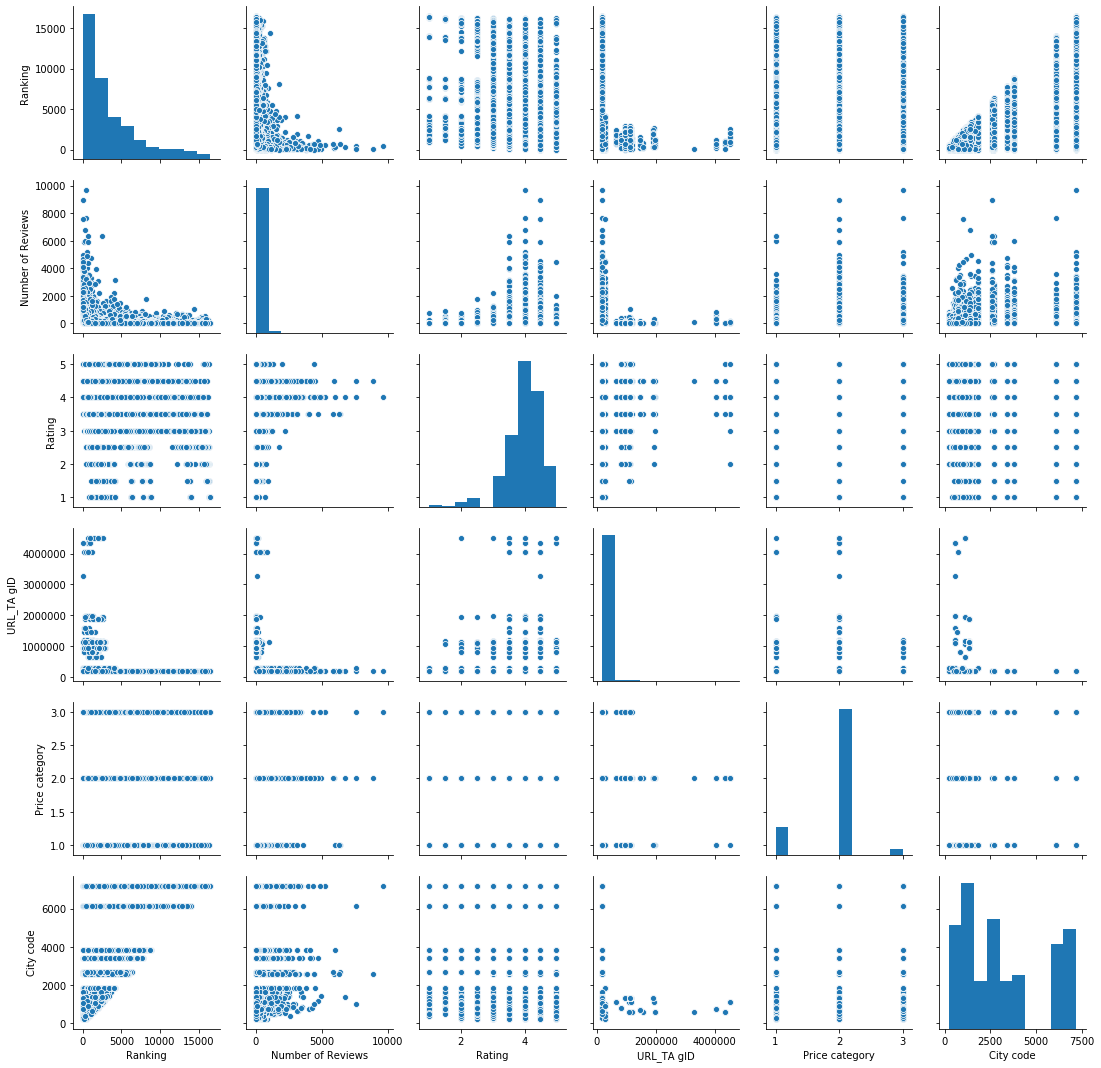

In [57]:
my_pairplot()

___

### [ ЧТО ЭТО ЗА ГОРОД? ] - столбец для каждого города (прямое кодирование городов)

In [58]:
train_model(display_df=0, display_importance=0) # предыдущий шаг


MAE: 0.21	Точность: 94.25 %
     0.19	          94.85 %	(после округления предсказанных значений)


In [59]:
# для каждого города свой столбец со значением 0 или 1
cities_dummies = pd.get_dummies(df_all['City'], prefix='city') # dummy_na=True

In [60]:
# добавляем полученные столбцы в основной датафрейм
df_all = df_all.join(cities_dummies)

In [61]:
train_model(unite=[['cities ALL']+list(cities_dummies.columns)])

,Ranking,Number of Reviews,Rating,URL_TA gID,Price category,City code,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,...,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
38699,4205.0,45.0,4.5,187147,2.0,6108,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0



MAE: 0.21	Точность: 94.27 %
     0.19	          94.85 %	(после округления предсказанных значений)
-------------------------------------------------
Переменная: Ranking              Значимость: 0.54
Переменная: Number of Reviews    Значимость: 0.18
Переменная: URL_TA gID           Значимость: 0.08
Переменная: City code            Значимость: 0.15

Переменная: Price category       Значимость: 0.01
Переменная: cities ALL SUM       Значимость: 0.04
-------------------------------------------------


Прямое кодирование городов ничего не изменило. Посмотрим на модель без 'City code'.

In [62]:
train_model(display_df=0, display_importance=0, delete=['City code'])


MAE: 0.21	Точность: 94.22 %
     0.19	          94.78 %	(после округления предсказанных значений)


Существенно ухудшается Точность. Проверим, какую роль играет 'URL_TA gID' теперь.

In [63]:
train_model(display_df=0, display_importance=0, delete=['URL_TA gID'])


MAE: 0.21	Точность: 94.26 %
     0.19	          94.85 %	(после округления предсказанных значений)


Никакую. УДАЛИМ его.

In [64]:
df_all.drop(['URL_TA gID'], axis=1, inplace=True)

In [65]:
my_heatmap(draw_heatmap=0)

[ 0.7 ] Ranking - City code
[ 0.7 ] City code - city_London
[ 0.5 ] Ranking - city_London
[ 0.5 ] City code - city_Paris


Не удивительно увидеть здесь именно эти 2 города: код London самый высокий - 5757, код Paris - 4897 (второй за Лондоном).

___

### [ ЭТОТ ГОРОД - СТОЛИЦА? ] - 'City capital'

In [66]:
# если столица страны (словарь сountries_info) города (словарь cities_info) и город совпадают, ставим 1, нет - 0
df_all['City capital'] = df_all.City.apply(lambda x: 1 
                                           if сountries_info[cities_info[x]['country']]['cap']==x else 0)

In [67]:
train_model(display_df=0, display_importance=0)


MAE: 0.21	Точность: 94.27 %
     0.19	          94.84 %	(после округления предсказанных значений)


Позитивной динамики от наличия признака 'City capital' нет, напротив - ухудшается Точность. УДАЛЯЕМ.

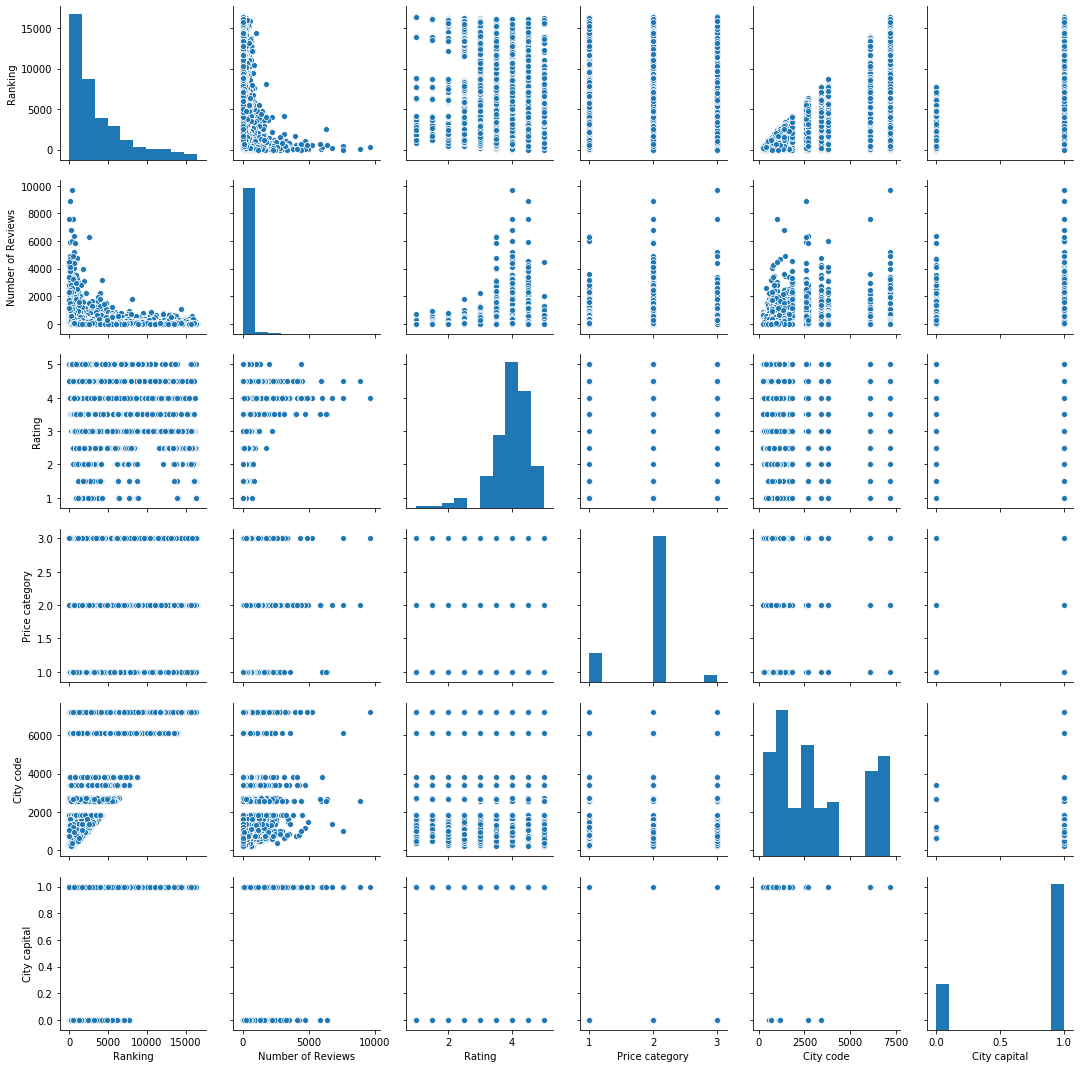

In [68]:
my_pairplot(delete=list(cities_dummies.columns))

In [69]:
df_all.drop(['City capital'], axis=1, inplace=True)

___

### [ МАНИПУЛЯЦИИ С ГОРОДАМИ: СТОЛИЦА? ] - столбцы городов + столица или нет
Посмотрим, что произойдет если столбцы городов ранжировать по принципу столица это или нет.

In [70]:
train_model(display_df=0, display_importance=0) # предыдущий шаг


MAE: 0.21	Точность: 94.26 %
     0.19	          94.85 %	(после округления предсказанных значений)


cities_dummies - РЕЗЕРВНАЯ КОПИЯ ПРЯМОГО КОДИРОВАНИЯ ГОРОДОВ ЧЕРЕЗ СТОЛБЦЫ СО ЗНАЧЕНИЯМИ 1 ИЛИ 0

In [71]:
# 10 - если это столица (столица страны (словарь сountries_info) города (словарь cities_info) и город совпадают),
# 5 - если не столица,
# 0 - не город ресторана
for city, info in cities_info.items():
    df_all['city_'+city] = df_all.City.apply(lambda x: 10 
                                     if x==city and сountries_info[cities_info[x]['country']]['cap']==x else 
                                     (5 if x==city else 0))

In [72]:
train_model(display_importance=0)

,Ranking,Number of Reviews,Rating,Price category,City code,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,...,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
25288,1644.0,13.0,4.5,2.0,1816,0,0,0,0,0,...,0,0,0,0,10,0,0,0,0,0



MAE: 0.21	Точность: 94.26 %
     0.19	          94.85 %	(после округления предсказанных значений)


Никакого эффекта. Информация о том, является ли город столицей, не имеет значения для модели. ВЕРНЕМ столбцы городов cities_dummies (значения 1/0).

In [73]:
df_all.drop(list(cities_dummies.columns), axis=1, inplace=True)
df_all = df_all.join(cities_dummies)

___

### [ ЧТО ЭТО ЗА СТРАНА? ] - столбец для каждой страны

In [74]:
# для каждого города в столбце нужной страны поставить 1
for country in сountries_info.keys():
    df_all['country_'+country] = df_all.City.apply(lambda x: 1 
                                                   if country==cities_info[x]['country'] else 0)

In [75]:
train_model(display_importance=0)

,Ranking,Number of Reviews,Rating,Price category,City code,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,...,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Scotland,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland
26410,9766.0,4.0,4.5,2.0,6108,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



MAE: 0.21	Точность: 94.27 %
     0.19	          94.83 %	(после округления предсказанных значений)


Никакого положительного эффекта - только ухудшается Точность. УДАЛИМ СТОЛБЦЫ СТРАН - они не представляют интереса и не добавляют новой информации, кроме очень высокой очевидной корреляции с городами.

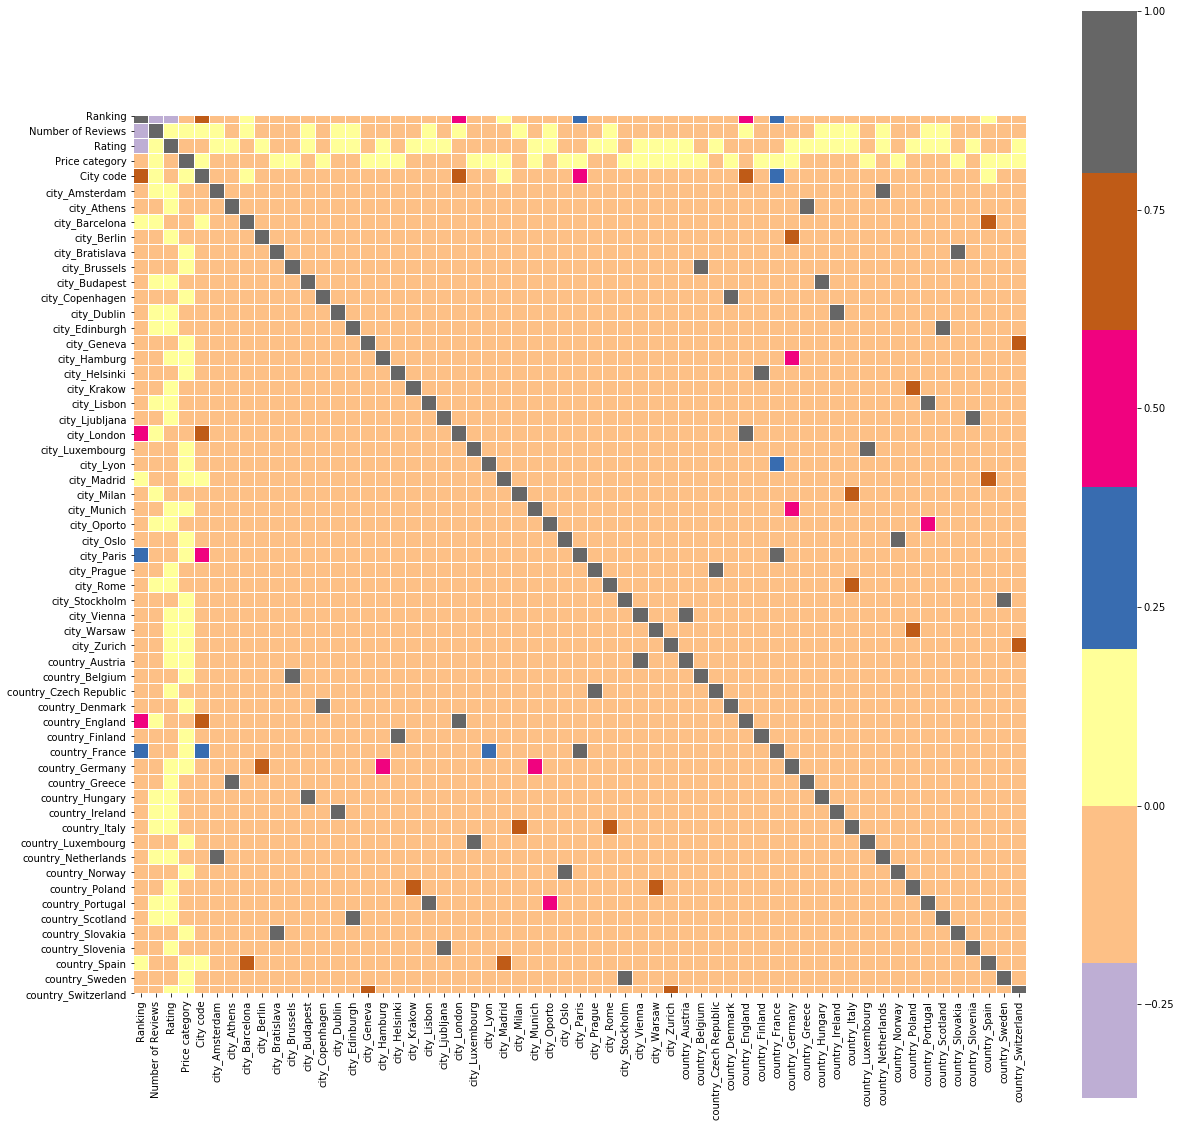

In [76]:
my_heatmap(display_correlation=0, heatmap_size=20)

In [77]:
for country in сountries_info.keys():
    df_all.drop(['country_'+country], axis=1, inplace=True)

___

### [ ПОПУЛЯЦИЯ И ОТЗЫВЫ ] - 'Population' и 'Population-Reviews corr'

In [78]:
train_model(display_df=0, display_importance=0) # предыдущий шаг


MAE: 0.21	Точность: 94.26 %
     0.19	          94.85 %	(после округления предсказанных значений)


In [79]:
# Популяция города
df_all['Population'] = df_all.City.apply(lambda x: cities_info[x]['pop'])

In [80]:
# Корреляция популяции города и количества отзывов
df_all['Population-Reviews corr'] = df_all.apply(lambda x: 
                                                 round(x['Number of Reviews']*100/x['Population'], 2), axis=1)

In [81]:
train_model(display_df=0, display_importance=0)


MAE: 0.21	Точность: 94.27 %
     0.19	          94.83 %	(после округления предсказанных значений)


[ 0.8 ] city_London - Population
[ 0.7 ] City code - Population
[ 0.7 ] Ranking - City code
[ 0.7 ] City code - city_London
[ 0.7 ] Number of Reviews - Population-Reviews corr
[ 0.5 ] Ranking - Population
[ 0.5 ] Ranking - city_London
[ 0.5 ] City code - city_Paris


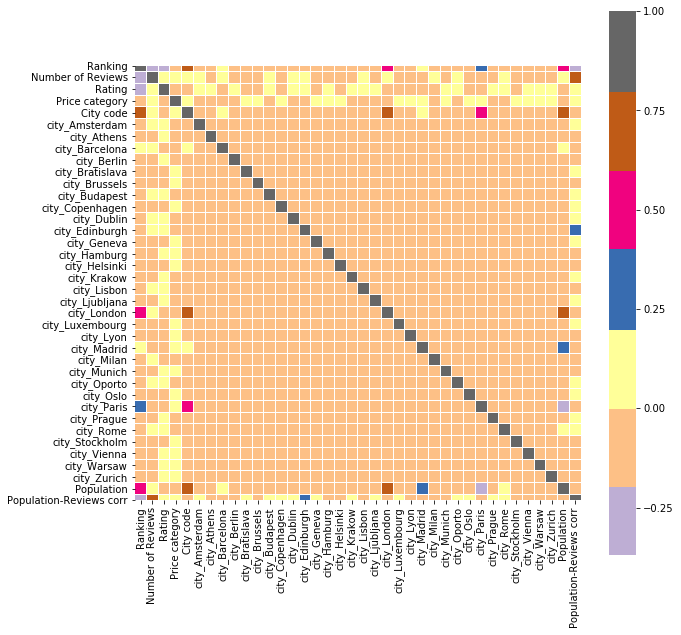

In [82]:
my_heatmap(heatmap_size=10)

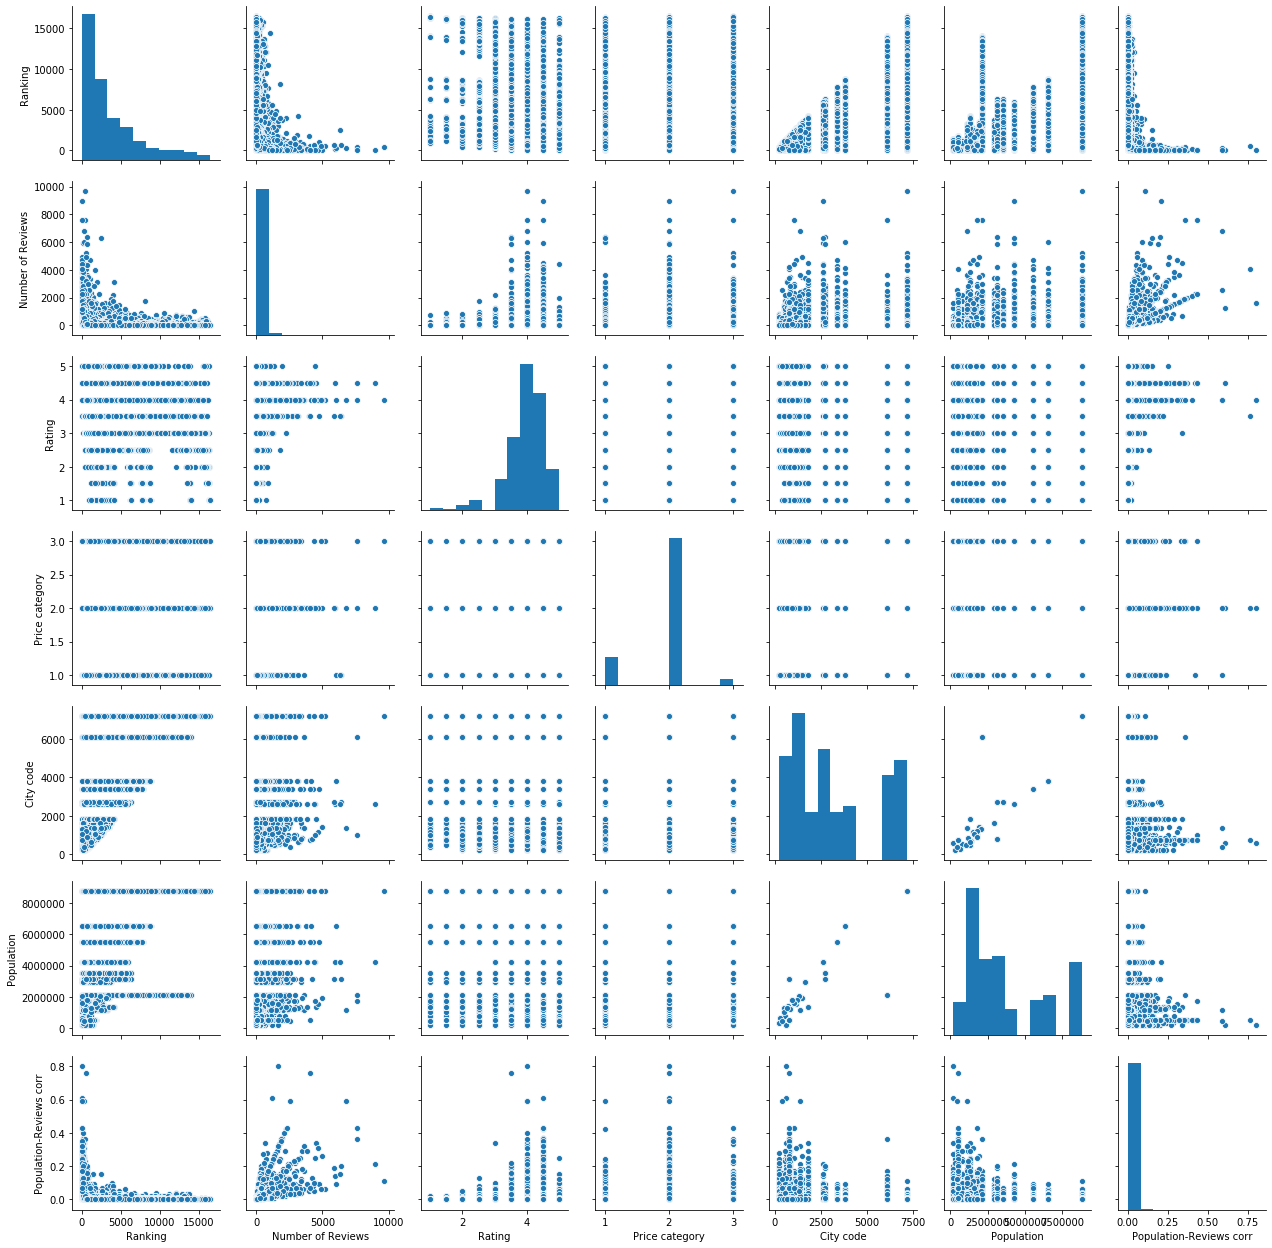

In [83]:
my_pairplot(delete=list(cities_dummies.columns))

Столбец популяции города 'Population' по сути выполняет такую же роль, как код города 'City code' - достаточно взглянуть на их графики в строке 'Rating', чтобы обнаружить их почти полную идентичность. Почти исключителная и довольно высокая корреляция 'Population-Reviews corr' и 'Number of Reviews' - логична и также отражается в почти полной идентичности их графиков. 'Population-Reviews corr' ничего интересного не дает. 'Population' & 'Population-Reviews corr' УДАЛЯЕМ.

In [84]:
df_all.drop(['Population', 'Population-Reviews corr'], axis=1, inplace=True)

___

### [ СКОЛЬКО КУХОНЬ В РЕСТОРАНЕ? ] - 'Cuisines number'

In [85]:
train_model(display_df=0, display_importance=0) # предыдущий шаг


MAE: 0.21	Точность: 94.26 %
     0.19	          94.85 %	(после округления предсказанных значений)


In [86]:
# значение 'Cuisines Number' равно длине списка из столбца 'Cuisine Style' или 0, если этот список пустой
df_all['Cuisines number']=df_all['Cuisine Style'].apply(lambda x: 
                                                        len(str(x).replace("['", "").
                                                            replace("']", "").
                                                            replace("', '", ",").
                                                            split(',')) 
                                                        if str(x).replace("['", "").
                                                        replace("']", "").
                                                        replace("', '", ",").split(',')[0]!='nan' else 0)

In [87]:
train_model(display_df=0, display_importance=0)


MAE: 0.21	Точность: 94.32 %
     0.18	          94.94 %	(после округления предсказанных значений)


In [88]:
my_heatmap(draw_heatmap=0)

[ 0.7 ] Ranking - City code
[ 0.7 ] City code - city_London
[ 0.5 ] Ranking - city_London
[ 0.5 ] City code - city_Paris


И MAE, и Точность ощутимо улучшились. Однако, 'Cuisines number' - СПОРНЫЙ ПАРАМЕТР (из-за разношерстности данных в 'Cuisine Style').

___

### [ информация о типах кухонь > в словарь ]

In [89]:
cuisines_dictionary = {} # словарь уникальных кухонь и их количества соответственно { кухня1: кол-во, ... }

# функция заполнения списка CuisinesList и словаря cuisines_dictionary
def cuisines_dictionary_fill(cuisines):
    global cuisines_dictionary
    # из входящей строки вида "['German', 'Central European', 'Vegetarian Friendly']"
    cuisines = str(cuisines).replace("['", "").replace("']", "").replace("', '", ",").split(',')
    # получили список отдельных значений вида ['German', 'Central European', 'Vegetarian Friendly']
    if cuisines[0]!='nan': # если список кухонь не пустой
        for i in cuisines: # перебор полученного списка
            if cuisines_dictionary.get(i)==None: # нет такой кухни в словаре cuisines_dictionary
                cuisines_dictionary[i] = 1 # добавить кухню (ключ) в cuisines_dictionary со значением 1
            else: cuisines_dictionary[i] += 1 # увеличить значение для этой кухни (ключа) в словаре cuisines_dictionary

df_all['Cuisine Style'].apply(cuisines_dictionary_fill)
print(sorted(cuisines_dictionary))

['Afghani', 'African', 'Albanian', 'American', 'Arabic', 'Argentinean', 'Armenian', 'Asian', 'Australian', 'Austrian', 'Azerbaijani', 'Balti', 'Bangladeshi', 'Bar', 'Barbecue', 'Belgian', 'Brazilian', 'Brew Pub', 'British', 'Burmese', 'Cafe', 'Cajun & Creole', 'Cambodian', 'Canadian', 'Caribbean', 'Caucasian', 'Central American', 'Central Asian', 'Central European', 'Chilean', 'Chinese', 'Colombian', 'Contemporary', 'Croatian', 'Cuban', 'Czech', 'Danish', 'Delicatessen', 'Diner', 'Dutch', 'Eastern European', 'Ecuadorean', 'Egyptian', 'Ethiopian', 'European', 'Fast Food', 'Filipino', 'French', 'Fujian', 'Fusion', 'Gastropub', 'Georgian', 'German', 'Gluten Free Options', 'Greek', 'Grill', 'Halal', 'Hawaiian', 'Healthy', 'Hungarian', 'Indian', 'Indonesian', 'International', 'Irish', 'Israeli', 'Italian', 'Jamaican', 'Japanese', 'Korean', 'Kosher', 'Latin', 'Latvian', 'Lebanese', 'Malaysian', 'Mediterranean', 'Mexican', 'Middle Eastern', 'Minority Chinese', 'Mongolian', 'Moroccan', 'Native

___

### [ МАНИПУЛЯЦИИ С КОЛИЧЕСТВОМ КУХОНЬ: СКОЛЬКО ЧЕГО? ] - '... number'
Что будет, если вместо 'Cuisines number' разбить кухни по категориям (тип заведения - Place, тип еды - Food, "здоровые" опции - Health и гео-привязка кухни - Geo) и указать количество для каждой из них?

In [90]:
train_model(display_df=0, display_importance=0) # предыдущий шаг


MAE: 0.21	Точность: 94.32 %
     0.18	          94.94 %	(после округления предсказанных значений)


In [91]:
cuisines_place = [ 'Bar', 'Brew Pub', 'Cafe', 'Cajun & Creole', 'Delicatessen', 'Diner', 'Gastropub', 'Pub', 
                  'Steakhouse', 'Wine Bar' ]
cuisines_food = [ 'Barbecue', 'Fast Food', 'Grill', 'Halal', 'Kosher', 'Pizza',  'Seafood', 'Soups', 
                 'Steakhouse', 'Street Food', 'Sushi' ]
cuisines_health = [ 'Healthy', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options' ]
    
cuisines_geo = []
for cuisine in cuisines_dictionary.keys():
    if cuisines_place.count(cuisine)==0 and cuisines_food.count(cuisine)==0 and cuisines_health.count(cuisine)==0: 
        cuisines_geo.append(cuisine)

print(sorted(cuisines_geo))

['Afghani', 'African', 'Albanian', 'American', 'Arabic', 'Argentinean', 'Armenian', 'Asian', 'Australian', 'Austrian', 'Azerbaijani', 'Balti', 'Bangladeshi', 'Belgian', 'Brazilian', 'British', 'Burmese', 'Cambodian', 'Canadian', 'Caribbean', 'Caucasian', 'Central American', 'Central Asian', 'Central European', 'Chilean', 'Chinese', 'Colombian', 'Contemporary', 'Croatian', 'Cuban', 'Czech', 'Danish', 'Dutch', 'Eastern European', 'Ecuadorean', 'Egyptian', 'Ethiopian', 'European', 'Filipino', 'French', 'Fujian', 'Fusion', 'Georgian', 'German', 'Greek', 'Hawaiian', 'Hungarian', 'Indian', 'Indonesian', 'International', 'Irish', 'Israeli', 'Italian', 'Jamaican', 'Japanese', 'Korean', 'Latin', 'Latvian', 'Lebanese', 'Malaysian', 'Mediterranean', 'Mexican', 'Middle Eastern', 'Minority Chinese', 'Mongolian', 'Moroccan', 'Native American', 'Nepali', 'New Zealand', 'Norwegian', 'Pakistani', 'Persian', 'Peruvian', 'Polish', 'Polynesian', 'Portuguese', 'Romanian', 'Russian', 'Salvadoran', 'Scandina

In [92]:
df_all['Geo number']=0
for geo in cuisines_geo:
    df_all['Geo number'] += df_all['Cuisine Style'].apply(lambda x: 1 if str(x).count(geo)>0 else 0)

In [93]:
df_all['Place number']=0
for place in cuisines_place:
    df_all['Place number'] += df_all['Cuisine Style'].apply(lambda x: 1 if str(x).count(place)>0 else 0)

In [94]:
df_all['Food number']=0
for food in cuisines_food:
    df_all['Food number'] += df_all['Cuisine Style'].apply(lambda x: 1 if str(x).count(food)>0 else 0)

In [95]:
df_all['Health number']=0
for health in cuisines_health:
    df_all['Health number'] += df_all['Cuisine Style'].apply(lambda x: 1 if str(x).count(health)>0 else 0)

In [96]:
df_all[['Cuisine Style', 'Cuisines number', 
        'Geo number', 'Place number', 'Food number', 'Health number']].tail(5)

,Cuisine Style,Cuisines number,Geo number,Place number,Food number,Health number
49995,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",4,1,0,0,3
49996,"['French', 'American', 'Bar', 'European', 'Veg...",5,3,1,0,1
49997,"['Japanese', 'Sushi']",2,1,0,1,0
49998,"['Polish', 'European', 'Eastern European', 'Ce...",5,4,0,0,1
49999,['Spanish'],1,1,0,0,0


In [97]:
train_model(display_df=0, display_importance=0)


MAE: 0.21	Точность: 94.3 %
     0.18	          94.95 %	(после округления предсказанных значений)


Слегка увеличилась Точность. Посмотрим, что будет без 'Cuisines number'

In [98]:
train_model(display_df=0, display_importance=0, delete=['Cuisines number'])


MAE: 0.21	Точность: 94.32 %
     0.18	          94.98 %	(после округления предсказанных значений)


Без 'Cuisines number' Точность модели лучше. Продолжим исследование.

### [ У РЕСТОРАНА УКАЗАНЫ: РЕГИОН, ТИП ЗАВЕДЕНИЯ, ТИП ЕДЫ, ЗДОРОВЫЕ ОПЦИИ? ] - 1/0

In [99]:
train_model(display_df=0, display_importance=0) # предыдущий шаг


MAE: 0.21	Точность: 94.3 %
     0.18	          94.95 %	(после округления предсказанных значений)


In [100]:
df_all['Geo'] = df_all['Geo number'].apply(lambda x: 1 if x>0 else 0)

In [101]:
df_all['Place'] = df_all['Place number'].apply(lambda x: 1 if x>0 else 0)

In [102]:
df_all['Food'] = df_all['Food number'].apply(lambda x: 1 if x>0 else 0)

In [103]:
df_all['Health'] = df_all['Health number'].apply(lambda x: 1 if x>0 else 0)

In [104]:
df_all[['Cuisine Style', 'Cuisines number', 'Geo number', 'Place number', 'Food number', 'Health number',
        'Geo', 'Place', 'Food', 'Health']].tail(5)

,Cuisine Style,Cuisines number,Geo number,Place number,Food number,Health number,Geo,Place,Food,Health
49995,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",4,1,0,0,3,1,0,0,1
49996,"['French', 'American', 'Bar', 'European', 'Veg...",5,3,1,0,1,1,1,0,1
49997,"['Japanese', 'Sushi']",2,1,0,1,0,1,0,1,0
49998,"['Polish', 'European', 'Eastern European', 'Ce...",5,4,0,0,1,1,0,0,1
49999,['Spanish'],1,1,0,0,0,1,0,0,0


In [105]:
# Cuisines number + Geo number, Place number, Food number, Health number + Geo, Place, Food, Health
train_model(display_df=0, display_importance=0)


MAE: 0.21	Точность: 94.31 %
     0.18	          94.97 %	(после округления предсказанных значений)


Точность чуть выше.

In [106]:
# Cuisines number + Geo, Place, Food, Health
train_model(display_df=0, display_importance=0, 
           delete=['Geo number', 'Place number', 'Food number', 'Health number'])


MAE: 0.21	Точность: 94.32 %
     0.18	          95.01 %	(после округления предсказанных значений)


Точность лучше, чем только при 'Cuisines number'.

In [107]:
# Geo number, Place number, Food number, Health number + Geo, Place, Food, Health
train_model(display_df=0, display_importance=0, delete=['Cuisines number'])


MAE: 0.21	Точность: 94.32 %
     0.18	          94.97 %	(после округления предсказанных значений)


Лучше всего будет оставить 'Cuisines number' + 'Geo', 'Place', 'Food', 'Health',  
а 'Geo number', 'Place number', 'Food number' и 'Health number' УДАЛИТЬ.

In [108]:
df_all.drop(['Geo number', 'Place number', 'Food number', 'Health number'], axis=1, inplace=True)

___

### [ КАКИЕ КУХНИ В РЕСТОРАНЕ? ] - столбцы для каждого типа кухонь

In [109]:
train_model(display_df=0, display_importance=0) # предыдущий шаг


MAE: 0.21	Точность: 94.32 %
     0.18	          95.01 %	(после округления предсказанных значений)


In [110]:
for cuisine in cuisines_dictionary.keys(): # список всех уникальных кухонь
    df_all[cuisine] = df_all['Cuisine Style'].apply(lambda x: 1 if str(x).count(cuisine)>0 else 0)

In [111]:
train_model(display_importance=0)

,Ranking,Number of Reviews,Rating,Price category,City code,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,...,Albanian,Central Asian,Polynesian,Caucasian,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian
19928,777.0,135.0,4.0,2.0,1314,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



MAE: 0.21	Точность: 94.34 %
     0.18	          95.03 %	(после округления предсказанных значений)


Точность немного увеличилась.

In [112]:
my_heatmap(draw_heatmap=0)

[ 1.0 ] Health - Vegetarian Friendly
[ 0.7 ] Place - Bar
[ 0.7 ] Ranking - City code
[ 0.7 ] City code - city_London
[ 0.7 ] Japanese - Sushi
[ 0.7 ] Cuisines number - Health
[ 0.7 ] Cuisines number - Vegetarian Friendly
[ 0.6 ] Cuisines number - Geo
[ 0.6 ] city_Budapest - Hungarian
[ 0.6 ] city_Prague - Czech
[ 0.6 ] Bar - Pub
[ 0.6 ] city_Ljubljana - Slovenian
[ 0.6 ] Vegetarian Friendly - Vegan Options
[ 0.5 ] city_Lisbon - Portuguese
[ 0.5 ] Health - Vegan Options
[ 0.5 ] city_Athens - Greek
[ 0.5 ] Place - Pub
[ 0.5 ] Cuisines number - Vegan Options
[ 0.5 ] Food - Pizza
[ 0.5 ] Health - Gluten Free Options
[ 0.5 ] Caribbean - Jamaican
[ 0.5 ] Place - Cafe
[ 0.5 ] Cuisines number - Gluten Free Options
[ 0.5 ] African - Ethiopian
[ 0.5 ] city_Dublin - Irish
[ 0.5 ] city_Amsterdam - Dutch
[ 0.5 ] Ranking - city_London
[ 0.5 ] Cuisines number - European
[ 0.5 ] city_Vienna - Austrian
[ 0.5 ] city_Edinburgh - Scottish
[ 0.5 ] Gluten Free Options - Vegan Options
[ 0.5 ] Middle Eastern 

Какие здесь напрашиваются выводы? Чаще всего из "здоровых опций" встречаются 'Vegeterian Friendly', которые в свою очередь соотносятся с наибольшими значениями 'Cuisines number' и часто попадаются вместе с 'Vegan Options'. Похоже, посетители охотнее и подробнее составляют список типов кухонь, давая отзыв ресторану, если в ресторане есть "здоровые опции". Тогда щедро отмечены и гео-признаки типов кухонь: французская, итальянская и тп. Часто встречаются рестораны с локальной кухней - посетители любят отведать местную стряпню. Из мест чаще всего отмечены БАРЫ, которые часто указаны вместе с ПАБАМИ - второе из самых часто указанных мест, опережающее КАФЕ. Из еды чаще всего отмечена ПИЦЦА, а СУШИ почти всегда указаны вместе с ЯПОНСКОЙ кухней.

___

### [ ТИП КУХНИ и МЕСТОПОЛОЖЕНИЕ ] - 'CuisineStyle Local', 'CuisineStyle Regional'
(Влияет ли на рейтинг, если в ресторане локальная кухня - город и/или регион соответствующей страны)

In [113]:
train_model(display_df=0, display_importance=0) # предыдущий шаг


MAE: 0.21	Точность: 94.34 %
     0.18	          95.03 %	(после округления предсказанных значений)


In [114]:
print(сountries_info[cities_info['Lyon']['country']]['cuis'], 
      сountries_info[cities_info['Lyon']['country']]['reg'])

French ['European', 'Mediterranean']


In [115]:
df_all['CuisineStyle Local'] = df_all.apply(lambda x: 1 
                                            if list(cuisines_dictionary.keys())
                                            .count(сountries_info[cities_info[x['City']]['country']]['cuis'])>0 
                                            and x[сountries_info[cities_info[x['City']]['country']]['cuis']]==1
                                            else 0, axis=1)

In [116]:
df_all['CuisineStyle Regional']=0
for city, data in cities_info.items():
    for region in сountries_info[data['country']]['reg']:
        df_all['CuisineStyle Regional'] = df_all.apply(lambda x: 1 if x[region]==1 and x['City']==city 
                                                       else x['CuisineStyle Regional'], axis=1)

In [117]:
df_all[df_all['City']=='Paris'][['City', 'Cuisine Style', 'French', 'European', 'Mediterranean', 
                                 'Cuisines number', 'Geo', 'Place', 'Food', 'Health', 
                                 'CuisineStyle Local', 'CuisineStyle Regional']].tail(5)

,City,Cuisine Style,French,European,Mediterranean,Cuisines number,Geo,Place,Food,Health,CuisineStyle Local,CuisineStyle Regional
49967,Paris,"['French', 'European', 'Gastropub', 'Vegetaria...",1,1,0,5,1,1,0,1,1,1
49991,Paris,"['French', 'Contemporary', 'Fusion', 'Gastropub']",1,0,0,4,1,1,0,0,1,0
49993,Paris,NaN,0,0,0,0,0,0,0,0,0,0
49994,Paris,"['French', 'Fast Food', 'Mediterranean', 'Heal...",1,0,1,4,1,0,1,1,1,1
49996,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",1,1,0,5,1,1,0,1,1,1


In [118]:
train_model(display_df=0, display_importance=0)


MAE: 0.21	Точность: 94.35 %
     0.18	          95.04 %	(после округления предсказанных значений)


Точность слегка выросла.

___

### [ ВОЗРАСТ ОТЗЫВОВ И ВРЕМЯ МЕЖДУ НИМИ ]

'Review1 date', 'Review2 date'

In [119]:
# сегодняшняя дата
date_now = datetime.now()

In [120]:
def reviews_dates_fill(reviews):
    global datetime, date, date_now, date_counter
    
    review_date = datetime.strptime('1990-01-01', '%Y-%m-%d')
    
    # Возможные значения столбца 'Reviews':
    # "[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]"
    # "[['Pastries have never tasted so good!'], ['06/16/2017']]"
    # "[[], []]"
    # Создадим список, оставив из значения только даты
    reviews_list = reviews[reviews.find("], [")+4:reviews.rfind("]]")].replace("'","").split(", ")
    
    if reviews_list[0]!='': # Если есть данные
        if date_counter==0 or (date_counter==1 and len(reviews_list)>1): # date_counter - внешний счетчик
            review_date = datetime.strptime(reviews_list[date_counter], '%m/%d/%Y').date()

    return review_date

In [121]:
for date_counter in range(0,2): # счетчик нужен, чтобы заполнить инфо для обеих дат (если они есть)
    df_all['Review'+str(date_counter+1)+' date'] = df_all.Reviews.apply(reviews_dates_fill)

In [122]:
df_all[['Reviews', 'Review1 date', 'Review2 date']].sample(3)

,Reviews,Review1 date,Review2 date
34976,"[['Slick and fast.', 'Excelelnt and quick'], [...",2017-05-07,2017-04-25
8925,"[['Lunch in the sun', 'Tasty tapas, terrible i...",2017-05-29,2017-02-05
8977,"[[], []]",1990-01-01,1990-01-01


### 'Review1 days', 'Review2 days', 'Review1 years', 'Review2 years'

In [123]:
train_model(display_df=0, display_importance=0, delete=['Review1 date', 'Review2 date']) # предыдущий шаг


MAE: 0.21	Точность: 94.35 %
     0.18	          95.04 %	(после округления предсказанных значений)


In [130]:
# Возраст отзывов, выраженный в днях; 
# вычисляется вычитанием сегодняшней даты из даты отзыва - отрицательный результат сохраняет приоритетность
# более новых отзывов относительно более старых; если дата не указана - используется дата 1990-01-01 
for i in range(1, 3):
    temp='Review'+str(i)+' '
    df_all[temp+'days'] = df_all[temp+'date'].apply(lambda x: 
                                                    int(str(x-date_now)[:str(x-date_now).find(" days"):]))
    df_all[temp+'years'] = df_all[temp+'days'].apply(lambda x: round(x/365, 1))

In [125]:
df_all[['Reviews', 'Review1 date', 'Review1 days', 'Review1 years', 
        'Review2 date', 'Review2 days', 'Review2 years']].sample(3)

,Reviews,Review1 date,Review1 days,Review1 years,Review2 date,Review2 days,Review2 years
6954,"[[""Give it a try you won't be dissapointed."", ...",2017-11-06,-910,-2.5,2017-10-20,-927,-2.5
34039,"[['Nice place', 'Simple, fast, good'], ['05/09...",2017-05-09,-1091,-3.0,2016-01-28,-1558,-4.3
20870,"[['Great food great service', 'Two good meals ...",2017-12-16,-870,-2.4,2017-08-31,-977,-2.7


In [126]:
train_model(display_df=0, delete=['Review1 date', 'Review2 date'], 
            unite=[['cities ALL']+list(cities_dummies.columns), 
                   ['cuisines ALL']+list(cuisines_dictionary.keys())])


MAE: 0.2	Точность: 94.45 %
     0.17	          95.2 %	(после округления предсказанных значений)
-------------------------------------------------
Переменная: Ranking              Значимость: 0.49
Переменная: Number of Reviews    Значимость: 0.14
Переменная: City code            Значимость: 0.21

Переменная: Price category       Значимость: 0.0
Переменная: Cuisines number      Значимость: 0.01
Переменная: Place                Значимость: 0.0
Переменная: CuisineStyle Local   Значимость: 0.0
Переменная: CuisineStyle Regional Значимость: 0.0
Переменная: Review1 days         Значимость: 0.02
Переменная: Review1 years        Значимость: 0.01
Переменная: Review2 days         Значимость: 0.02
Переменная: Review2 years        Значимость: 0.01
Переменная: cities ALL SUM       Значимость: 0.04
Переменная: cuisines ALL SUM     Значимость: 0.04
-------------------------------------------------


Значительно улучшились значения как MAE, так и Точности.

### 'ReviewsDIFF days', 'ReviewsDIFF years'

In [127]:
df_all['ReviewsDIFF days']=-abs(abs(df_all['Review1 days'])-abs(df_all['Review2 days']))
df_all['ReviewsDIFF years']=df_all['ReviewsDIFF days'].apply(lambda x: round(x/365, 1))

In [132]:
train_model(display_df=0, delete=['Review1 date', 'Review2 date'],
            unite=[['cities ALL']+list(cities_dummies.columns), 
                   ['cuisines ALL']+list(cuisines_dictionary.keys())])


MAE: 0.2	Точность: 94.41 %
     0.17	          95.2 %	(после округления предсказанных значений)
-------------------------------------------------
Переменная: Ranking              Значимость: 0.49
Переменная: Number of Reviews    Значимость: 0.14
Переменная: City code            Значимость: 0.21

Переменная: Price category       Значимость: 0.0
Переменная: Cuisines number      Значимость: 0.01
Переменная: Place                Значимость: 0.0
Переменная: CuisineStyle Local   Значимость: 0.0
Переменная: CuisineStyle Regional Значимость: 0.0
Переменная: Review1 days         Значимость: 0.02
Переменная: Review1 years        Значимость: 0.01
Переменная: Review2 days         Значимость: 0.01
Переменная: Review2 years        Значимость: 0.01
Переменная: ReviewsDIFF days     Значимость: 0.01
Переменная: ReviewsDIFF years    Значимость: 0.01
Переменная: cities ALL SUM       Значимость: 0.04
Переменная: cuisines ALL SUM     Значимость: 0.04
-------------------------------------------------


Разница в возрасте между отзывами ухудшает Точность.

In [133]:
df_all.drop(['ReviewsDIFF days', 'ReviewsDIFF years'], axis=1, inplace=True)

___

### [ МЕСЯЦЫ И ДНИ НЕДЕЛИ ОТЗЫВОВ ] - 'Review... month', 'Review... weekday'
Такая информация может быть интересна с точки зрения сезонности отзывов и их зависимости от дней месяца и недели.

In [134]:
days = [x for x in range(1, 32)]
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
          'September', 'October', 'November', 'December'] # значения 1 - 12
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] # значения 0 - 6

In [135]:
train_model(display_df=0, display_importance=0, delete=['Review1 date', 'Review2 date']) # предыдущий шаг


MAE: 0.2	Точность: 94.45 %
     0.17	          95.2 %	(после округления предсказанных значений)


In [136]:
for i in range(1,3):
    A='Review'+str(i)
    B='Review'+str(i)+' date'
    df_all[A+' month'] = df_all[B].apply(lambda x: x.month if x.year!=1990 else -1)
    df_all[A+' weekday'] = df_all[B].apply(lambda x: x.weekday() if x.year!=1990 else -1)

In [137]:
df_all[['Review1 date', 'Review1 days', 'Review1 years', 'Review1 month', 'Review1 weekday', 
        'Review2 date', 'Review2 days', 'Review2 years', 'Review2 month', 'Review2 weekday']].sample(5)

,Review1 date,Review1 days,Review1 years,Review1 month,Review1 weekday,Review2 date,Review2 days,Review2 years,Review2 month,Review2 weekday
5330,2017-11-12,-904,-2.5,11,6,2017-04-16,-1114,-3.1,4,6
38926,2012-12-09,-2703,-7.4,12,6,1990-01-01,-11081,-30.4,-1,-1
41336,2017-11-27,-889,-2.4,11,0,2017-11-07,-909,-2.5,11,1
44665,2017-12-17,-869,-2.4,12,6,2017-08-10,-998,-2.7,8,3
24020,2017-09-10,-967,-2.6,9,6,2017-08-11,-997,-2.7,8,4


In [138]:
train_model(display_df=0, display_importance=0, delete=['Review1 date', 'Review2 date'])


MAE: 0.2	Точность: 94.41 %
     0.17	          95.19 %	(после округления предсказанных значений)


Никакого эффекта, Точность чуть хуже. УДАЛЯЕМ.

In [139]:
df_all.drop(['Review1 month', 'Review2 month', 'Review1 weekday', 'Review2 weekday'], axis=1, inplace=True)

___

### [ СТОЛБЦЫ ДЛЯ КАЖДОГО МЕСЯЦА И ДНЯ НЕДЕЛИ ]
('RM_January', 'RM_February', ..., 'RW_Monday', 'RW_Tuesday', ...)

In [140]:
for mnth in months:
    df_all['RM_'+mnth]=0
    df_all['RM_'+mnth]+=df_all['Review1 date'].apply(lambda x: 1 if months[x.month-1]==mnth 
                                                     and x.year!=1990 else 0)
    df_all['RM_'+mnth]+=df_all['Review2 date'].apply(lambda x: 1 if months[x.month-1]==mnth 
                                                     and x.year!=1990 else 0)

In [141]:
for wkdy in weekdays:
    df_all['RW_'+wkdy]=0
    df_all['RW_'+wkdy]+=df_all['Review1 date'].apply(lambda x: 1 if weekdays[x.weekday()]==wkdy 
                                                     and x.year!=1990 else 0)
    df_all['RW_'+wkdy]+=df_all['Review2 date'].apply(lambda x: 1 if weekdays[x.weekday()]==wkdy 
                                                     and x.year!=1990 else 0)

In [142]:
ShowMonthsWeekdaysCols=[]
for mnth in months:
    ShowMonthsWeekdaysCols.append('RM_'+mnth)
for wkdy in weekdays:
    ShowMonthsWeekdaysCols.append('RW_'+wkdy)

In [143]:
df_all[['Review1 date', 'Review2 date']+ShowMonthsWeekdaysCols].sample(5)

,Review1 date,Review2 date,RM_January,RM_February,RM_March,RM_April,RM_May,RM_June,RM_July,RM_August,...,RM_October,RM_November,RM_December,RW_Monday,RW_Tuesday,RW_Wednesday,RW_Thursday,RW_Friday,RW_Saturday,RW_Sunday
43326,1990-01-01,1990-01-01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11415,2017-02-20,2016-12-30,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
11325,2017-10-30,2017-09-10,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
21507,2016-01-25,1990-01-01,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
27529,2017-01-28,1990-01-01,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [144]:
train_model(display_df=0, display_importance=0, delete=['Review1 date', 'Review2 date']) # предыдущий шаг


MAE: 0.2	Точность: 94.43 %
     0.18	          95.15 %	(после округления предсказанных значений)


Стало заметно хуже. УДАЛЯЕМ.

In [145]:
df_all.drop(ShowMonthsWeekdaysCols, axis=1, inplace=True)

___

Финальная модель.

In [147]:
train_model(display_df=0, delete=['Review1 date', 'Review2 date'], 
            unite=[['сities ALL']+list(cities_dummies.columns), 
                   ['cuisines ALL']+list(cuisines_dictionary.keys())])


MAE: 0.2	Точность: 94.45 %
     0.17	          95.2 %	(после округления предсказанных значений)
-------------------------------------------------
Переменная: Ranking              Значимость: 0.49
Переменная: Number of Reviews    Значимость: 0.14
Переменная: City code            Значимость: 0.21

Переменная: Price category       Значимость: 0.0
Переменная: Cuisines number      Значимость: 0.01
Переменная: Place                Значимость: 0.0
Переменная: CuisineStyle Local   Значимость: 0.0
Переменная: CuisineStyle Regional Значимость: 0.0
Переменная: Review1 days         Значимость: 0.02
Переменная: Review1 years        Значимость: 0.01
Переменная: Review2 days         Значимость: 0.02
Переменная: Review2 years        Значимость: 0.01
Переменная: сities ALL SUM       Значимость: 0.04
Переменная: cuisines ALL SUM     Значимость: 0.04
-------------------------------------------------


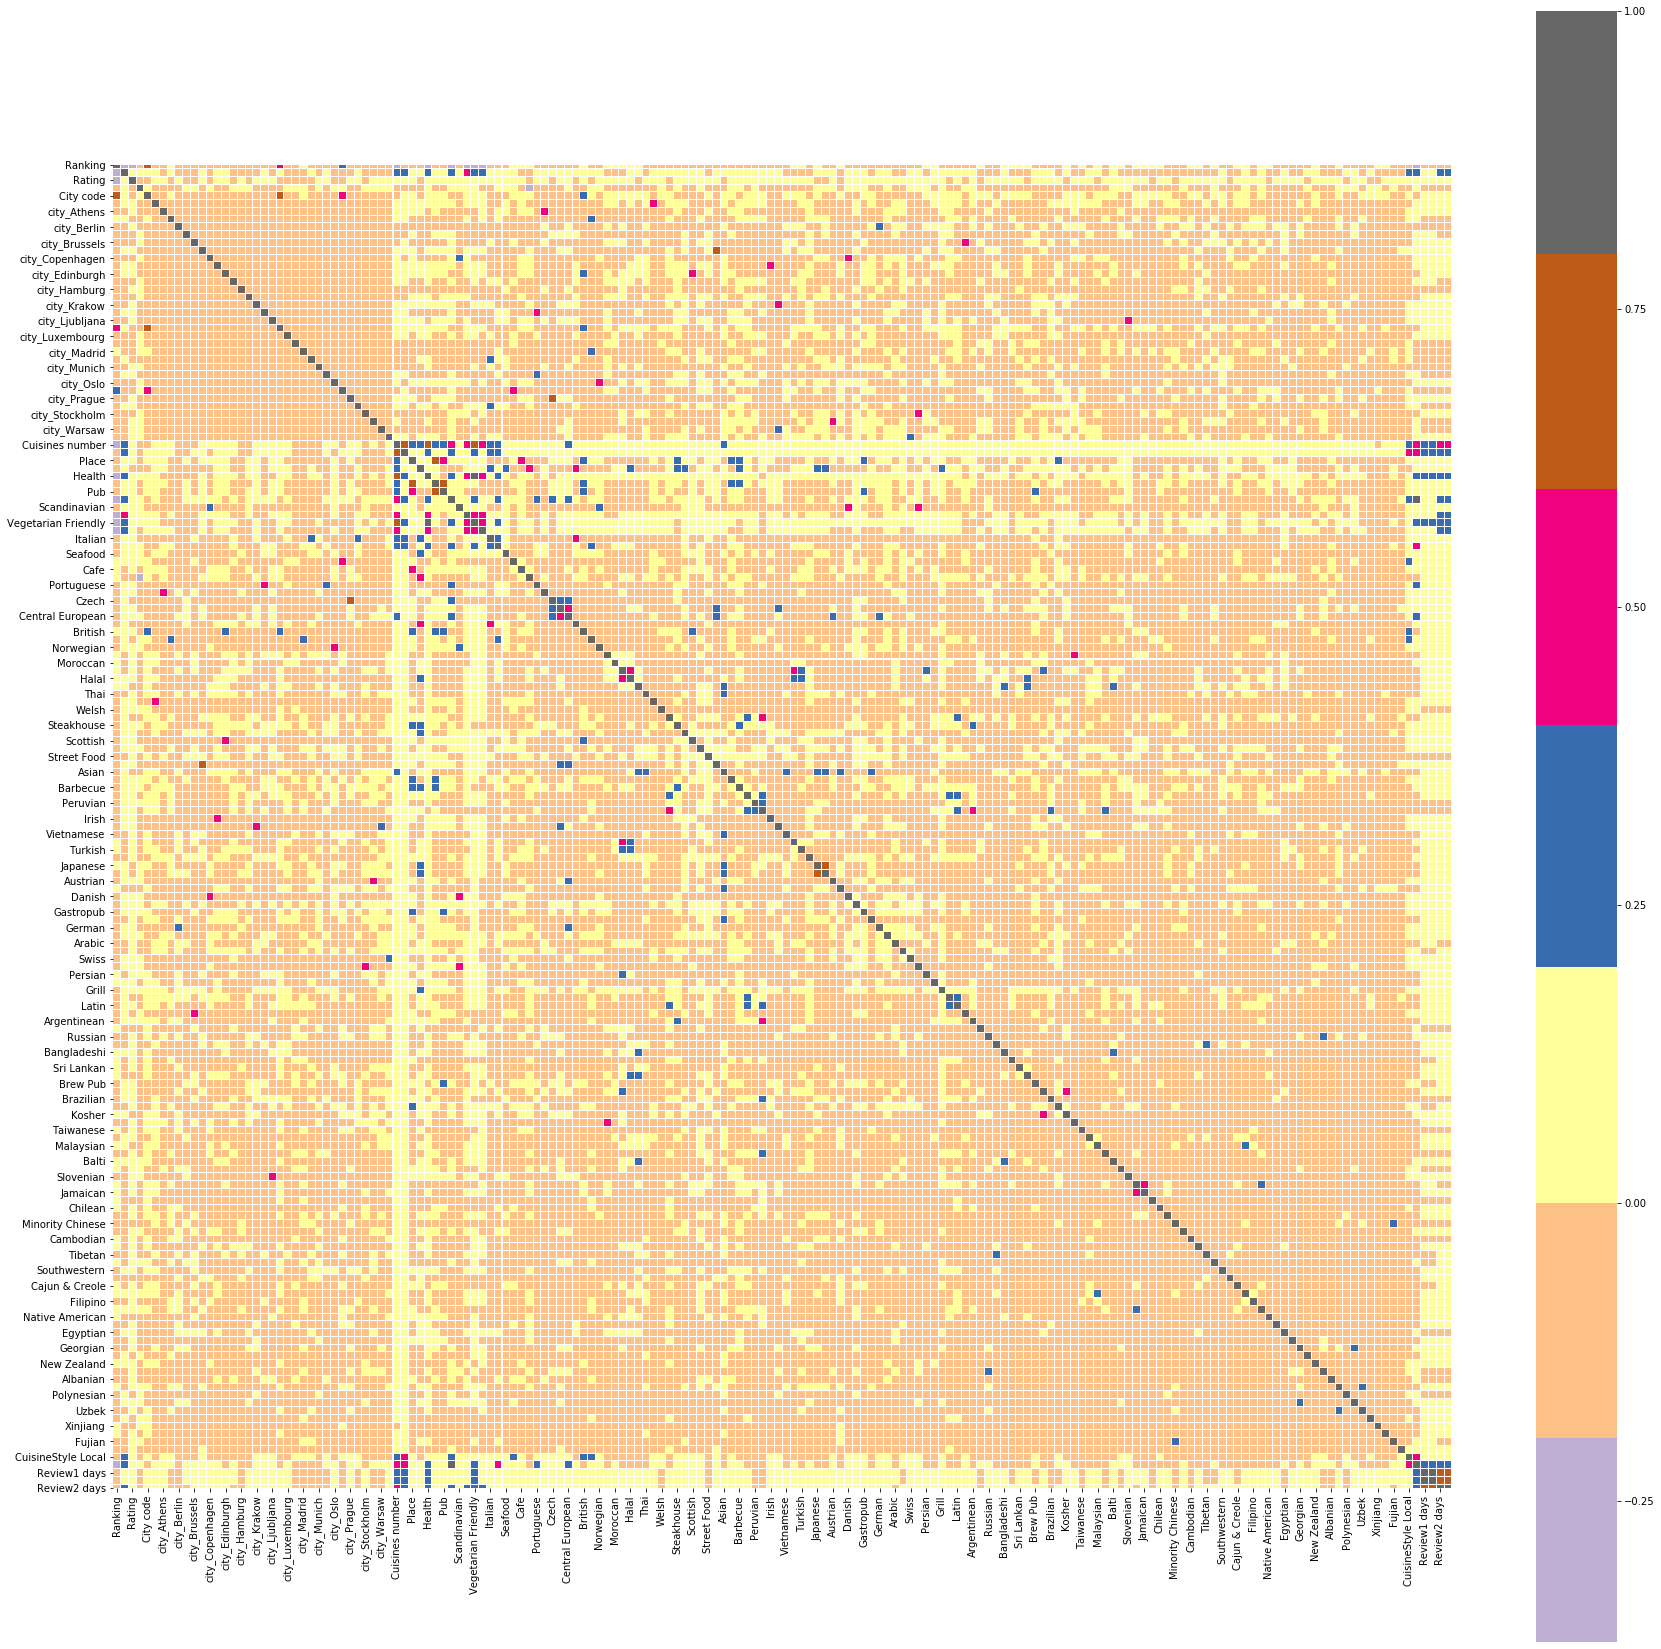

In [148]:
my_heatmap(heatmap_size=30, display_correlation=0)

___

# Конец кода по очистке данных и генерации новых признаков

___

In [152]:
# УБИРАЕМ ВСЕ ЛИШНИЕ СТОЛБЦЫ (нечисловые данные) ИЗ ДАТАФРЕЙМА
# Создаем список столбцов для удаления из датафрейма
drop_columns = [column for column in df_all.columns if df_all[column].dtypes=='object']
drop_columns += ['Review1 date', 'Review2 date']
# Удаляем из df_all все столбцы из списка drop_columns и сохраняем результат в новый датафрейм df
df = df_all.drop(drop_columns, axis=1) # df - столбцы с числовыми данными
df = df.fillna(0) # Заполняем пропуски в df 0 (нулями)

## Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [153]:
# РАЗБИВАЕМ ДАТАФРЕЙМ НА ЧАСТИ, НЕОБХОДИМЫЕ ДЛЯ ОБУЧЕНИЯ И ТЕСТИРОВАНИЯ МОДЕЛИ:
train_data = df.query('sample == 1').drop(['sample'], axis=1)
X = train_data.drop(['Rating'], axis=1) # Х - данные с информацией о ресторанах
y = train_data['Rating'] # у - целевая переменная (рейтинги ресторанов)

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
# Нужный инструмент для разбивки уже загружен:
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_seed)

## Создаём, обучаем и тестируем модель

In [154]:
# СОЗДАЁМ, ОБУЧАЕМ И ТЕСТИРУЕМ МОДЕЛЬ:
# Необходимые библиотеки уже импортированы:
#from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
#from sklearn import metrics # инструменты для оценки точности модели

# Создаём модель
regr = RandomForestRegressor(n_estimators=100, random_state=random_seed) # , verbose=1, n_jobs=-1
# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = np.round(regr.predict(X_test), 1)

In [155]:
# MAE - СРАВНИВАЕМ ПРЕДСКАЗАННЫЕ ЗНАЧЕНИЯ (y_pred) С РЕАЛЬНЫМИ (y_test):
MAE = metrics.mean_absolute_error(y_test, y_pred)
print('\nMAE:', round(MAE, 2), end='\t')

# ACCURACY - ОПРЕДЕЛЯЕМ ПОКАЗАТЕЛИ ЭФФЕКТИВНОСТИ:
errors = abs(y_pred - y_test) # считаем абсолютые ошибки
mape = 100 * (errors / y_test) # считаем средний абсолютный процент ошибки (MAPE)
accuracy = 100 - np.mean(mape) # считаем и выводим точность
print('Точность:', round(accuracy, 2), '%')

# ОКРУГЛЯЕМ ПРЕДСКАЗАННЫЕ ЗНАЧЕНИЯ В СООТВЕТСТВИИ С ШАГОМ ЗНАЧЕНИЙ РЕЙТИНГА
# (1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0)
for i in range(0,len(y_pred)): y_pred[i]=(round(y_pred[i]*2,0)/2)
MAE = metrics.mean_absolute_error(y_test, y_pred) # = abs(y_pred - y_test)
print('    ', round(MAE, 2), end='\t')
errors = abs(y_pred - y_test) # считаем абсолютые ошибки
mape = 100 * (errors / y_test) # считаем средний абсолютный процент ошибки (MAPE)
accuracy = 100 - np.mean(mape) # считаем и выводим точность
print('         ', round(accuracy, 2), '%\t(после округления предсказанных значений)')


MAE: 0.2	Точность: 94.45 %
     0.17	          95.2 %	(после округления предсказанных значений)


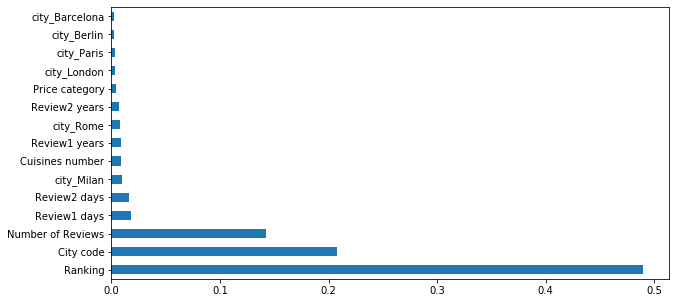

In [156]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 5)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

## Предсказываем рейтинг

In [157]:
test_data = df.query('sample == 0').drop(['sample'], axis=1)
test_data.sample(10)

,Ranking,Number of Reviews,Rating,Price category,City code,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,...,Xinjiang,Burmese,Fujian,Latvian,CuisineStyle Local,CuisineStyle Regional,Review1 days,Review1 years,Review2 days,Review2 years
5971,6541.0,9.0,0.0,2.0,6108,0,0,0,0,0,...,0,0,0,0,1,0,-11081,-30.4,-11081,-30.4
2579,170.0,223.0,0.0,3.0,819,0,0,0,0,0,...,0,0,0,0,0,1,-1122,-3.1,-1144,-3.1
3243,2393.0,8.0,0.0,2.0,1443,0,0,0,0,0,...,0,0,0,0,0,0,-1073,-2.9,-1249,-3.4
3593,1598.0,5.0,0.0,2.0,1816,0,0,0,0,0,...,0,0,0,0,0,0,-1219,-3.3,-1236,-3.4
6218,2691.0,88.0,0.0,2.0,7193,0,0,0,0,0,...,0,0,0,0,0,0,-846,-2.3,-847,-2.3
7850,60.0,589.0,0.0,2.0,590,0,0,0,0,0,...,0,0,0,0,1,1,-851,-2.3,-873,-2.4
2382,15205.0,5.0,0.0,2.0,7193,0,0,0,0,0,...,0,0,0,0,0,0,-964,-2.6,-930,-2.5
385,891.0,3.0,0.0,2.0,475,0,0,0,0,0,...,0,0,0,0,0,0,-1899,-5.2,-11081,-30.4
4975,1096.0,3.0,0.0,1.0,776,0,1,0,0,0,...,0,0,0,0,1,0,-11081,-30.4,-11081,-30.4
7558,67.0,236.0,0.0,2.0,819,0,0,0,0,0,...,0,0,0,0,0,1,-846,-2.3,-873,-2.4


In [158]:
# test_data - данные с информацией о ресторанах, тестовая выборка
test_data.drop(['Rating'], axis=1, inplace=True)

In [159]:
# используем обученную на тестовом наборе (X_train, y_train) данных модель regr для предсказания рейтинга 
# ресторанов в тестовой выборке test_data
# предсказанные значения записываем в переменную predict_submission
predict_submission = np.round(regr.predict(test_data), 1)
predict_submission[:15]

array([3.1, 4.1, 4.4, 4.3, 4.5, 4.5, 1.8, 2.6, 3.8, 4.7, 4.1, 3.6, 4.1,
       4. , 3.8])

In [160]:
# ОКРУГЛЯЕМ ПРЕДСКАЗАННЫЕ ЗНАЧЕНИЯ В СООТВЕТСТВИИ С ШАГОМ ЗНАЧЕНИЙ РЕЙТИНГА
# (1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0)
for i in range(0,len(predict_submission)): predict_submission[i]=(round(predict_submission[i]*2,0)/2)
predict_submission[:15]

array([3. , 4. , 4.5, 4.5, 4.5, 4.5, 2. , 2.5, 4. , 4.5, 4. , 3.5, 4. ,
       4. , 4. ])

In [161]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv(directory+filename_submission, index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5
